In [13]:
import numpy as np
import pandas as pd
from scipy import stats
import scipy.stats as st
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from IPython.display import Image

Hay una diferencia sustancial en el enfoque entre las pruebas de hipótesis y el modelado estadístico. 

Con las pruebas de hipótesis, normalmente se comienza con una hipótesis nula. 

Con base en la pregunta y los datos, se selecciona la prueba estadística adecuada, así como el nivel de significación deseado, y se acepta o se rechaza la hipótesis nula. 

El modelado estadístico implica un análisis más interactivo de los datos. 

Uno comienza con una inspección visual de los datos, buscando correlaciones y/o relaciones. 

Con base en esta primera inspección, se selecciona un modelo estadístico que pueda describir los datos. 

En casos simples, la relación en los datos se puede describir con un modelo de modelo lineal

$ y = m * x + b $

Se determinan los parámetros del modelo
- m: multiplicador 
- b: sesgo 

Se evalúa la calidad del modelo

Se inspeccionan los residuos (errores restantes), para verificar si el modelo propuesto ha perdido características esenciales en los datos. 

Si los residuales son demasiado grandes, o si la inspección visual de los residuales muestra valores atípicos o sugiere otro modelo, se modifica el modelo. 

Este procedimiento se repite hasta que los resultados sean satisfactorios. 

# 12.1 Ajustes simples

Ej: Conjunto de datos con ruido donde conocemos los parámetros verdaderos, un plano con ruido en 3D.

In [2]:
# Datos
np.random.seed(12345)
x = np.random.randn(100)*30
y = np.random.randn(100)*10
z = 3 + 0.4*x + 0.5*y + 10*np.random.randn(len(x))

In [3]:
df = pd.DataFrame({
    'x': x,
    'y': y,
    'z': z
})

df.head()

,x,y,z
0,-6.141230,-15.656573,3.990033
1,14.368300,-5.625402,0.250985
2,-15.583161,-0.326641,-0.302964
3,-16.671909,-9.290062,-14.087649
4,58.973417,-4.825726,12.490163


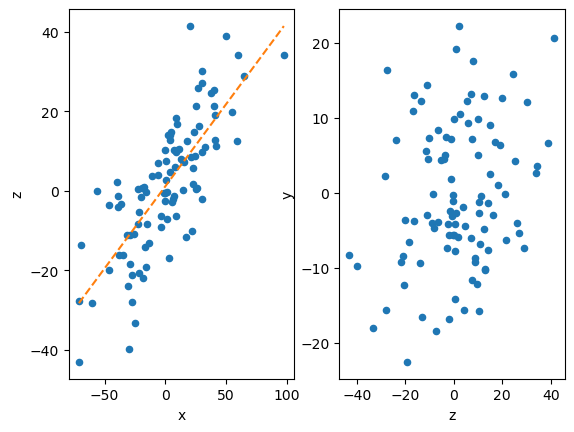

In [5]:
# Grafico
fig, axs = plt.subplots(1,2)

df.plot('x', 'z', kind = 'scatter', ax = axs[0])
df.plot('z', 'y', kind = 'scatter', ax = axs[1])

p = np.polyfit(df.x, df.z, 1)
x = np.linspace(df.x.min(), df.x.max(), 100)
axs[0].plot(x, np.polyval(p, x), color='C1', ls='dashed')

plt.show()

Dado que la inspección visual muestra una clara correlación lineal, podemos ajustar una línea a los datos $\frac{x}{z}$

In [7]:
# Regresión lineal simple
results = pg.linear_regression(df.x, df.z)
results.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.12,1.06,1.05,0.29,0.6,0.59,-0.99,3.23
1,x,0.41,0.03,12.10,0.00,0.6,0.59,0.35,0.48


In [9]:
results.pval.values

array([2.94862264e-01, 3.67185827e-21])

In [10]:
print(f'p = {results.pval.values[1]:4.1e}.') 

p = 3.7e-21.


In [12]:
results.pval

0    2.948623e-01
1    3.671858e-21
Name: pval, dtype: float64

La recta que mejor se ajusta a los datos es 

$ z = 0.41 ∗ x + 1.12 $

In [14]:
alpha = 0.05

if results.pval[0] < alpha:
    print(f'El intercepto es significativo porque la probabilidad de que el intercepto sea igual a cero es {results.pval[0]:.4}')
else:
    print(f'El intercepto no es significativo porque la probabilidad de que el intercepto sea igual a cero es {results.pval[0]:.4}')

El intercepto no es significativo porque la probabilidad de que el intercepto sea igual a cero es 0.2949


El intervalo de confianza del 95% correspondiente (95-%IC I = [-0.99 , 3.23]) se superpone a cero. 

La línea crece significativamente, ya que ambos extremos del intervalo de confianza del 95 % para “x” son mayores que 0 (95 %-C I = [0.35 0.48]). 

Si ambos estuvieran por debajo de cero, la línea se llamaría significativamente descendente

Si el IC del 95% se superpusiera a cero, la línea no tendría una pendiente significativa. 

Esto se refleja en $p < 0.05$. 

$p < 0.001$: la línea crece incluso de manera muy significativa. 

Las variables $x$ e $y$ son completamente independientes entre sí.

In [15]:
results = pg.linear_regression(df[['x','y']], df['z'])
results.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.28,0.96,1.33,0.19,0.67,0.67,-0.63,3.19
1,x,0.42,0.03,13.52,0.00,0.67,0.67,0.36,0.48
2,y,0.47,0.10,4.71,0.00,0.67,0.67,0.27,0.67


In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

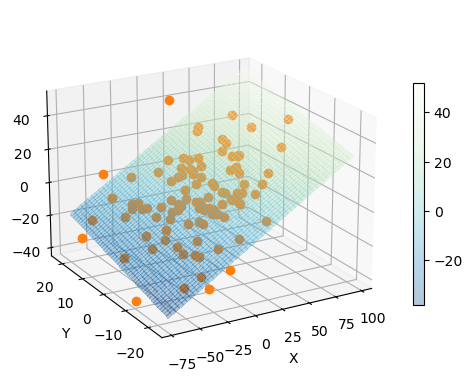

In [16]:
x = np.linspace(df.x.min(),df.x.max(),101)
y = np.linspace(df.y.min(),df.y.max(),101)
(X,Y) = np.meshgrid(x,y)
Z = results.coef[0] + results.coef[1]*X + results.coef[2]*Y

# Establecer el color
myCmap = cm.GnBu_r

# Mapa de colores de seaborn:
# from matplotlib.colors import ListedColormap
# myCmap = ListedColormap(sns.color_palette("Blues", 20))

# Grafico
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X,Y,Z, cmap=myCmap, rstride=2, cstride=2,
                       linewidth=0, antialiased=False, alpha=0.3)
ax.view_init(20,-120)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

fig.colorbar(surf, shrink=0.6)

ax.plot(df.x, df.y, df.z, 'o')

plt.show()

In [18]:
alpha = 0.05

if results.pval[0] < alpha:
    print(f'Hay una dependencia significativa de z y el intercepto. {results.pval[0]:.4}')
else:
    print(f'No hay una dependencia significativa de z y el intercepto. {results.pval[0]:.4}')

No hay una dependencia significativa de z y el intercepto. 0.1873


El IC del 95 % correspondiente = [-0.63	3.19] se superpone a cero.

# 12.2 Matriz de diseño y fórmulas

## 12.2.1 Ejemplo 1: Regresión lineal simple

Hay 7 puntos de datos $\{y_i, x_i\}$, donde $i = 1, 2, ..., 7$ 

Modelo de regresión lineal simple

$ y_i = \beta_0 + \beta_1 x_i + \epsilon_i$

$\beta_0$: intercepto
$\beta_1$: pendiente de la regresión lineal

Este modelo se puede representar en forma matricial como

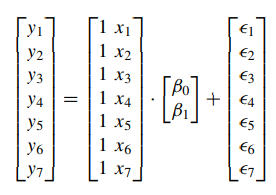

In [20]:
Image(filename = 'Imagenes/formula12.2.png')

Esta matriz se denomina “matriz de diseño”. 

## 12.2.2 Ejemplo 2: Ajuste cuadrático

La ecuación para un ajuste cuadrático a los datos dados es

$ y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 +\epsilon_i$

Matricialmente

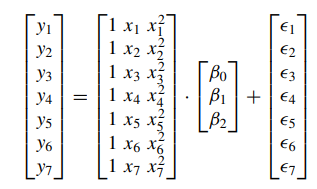

In [21]:
Image(filename = 'Imagenes/formula12.4.png')

Los parámetros desconocidos $\beta_i$ ingresan solo linealmente

Los componentes cuadráticos están restringidos a la matriz de datos (conocida). 

El ajuste requerido para determinar los parámetros $\beta_i$ es un ajuste lineal, aunque la curva sea cuadrática.

## 12.2.3 Regresión multilineal

Es una extensión directa de la regresión lineal simple.

La usamos si tenemos variables verdaderamente independientes. 

Ej: una regresión múltiple con covariables (variables independientes) $w_i$ y $x_i$. 

Suponga que los datos son 7 observaciones, y para cada valor observado que se va a predecir ($y_i$) 

Hay 2 covariables que también se observaron, $w_i$ y $x_i$. 

Modelando

$ y_i = \beta_0 + \beta_1 w_i + \beta_2 x_i +\epsilon_i$

Matricialmente

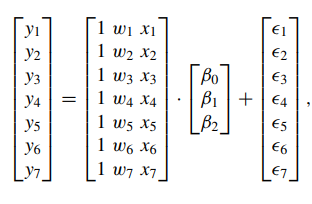

In [23]:
Image(filename = 'Imagenes/formula12.6.png')

C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


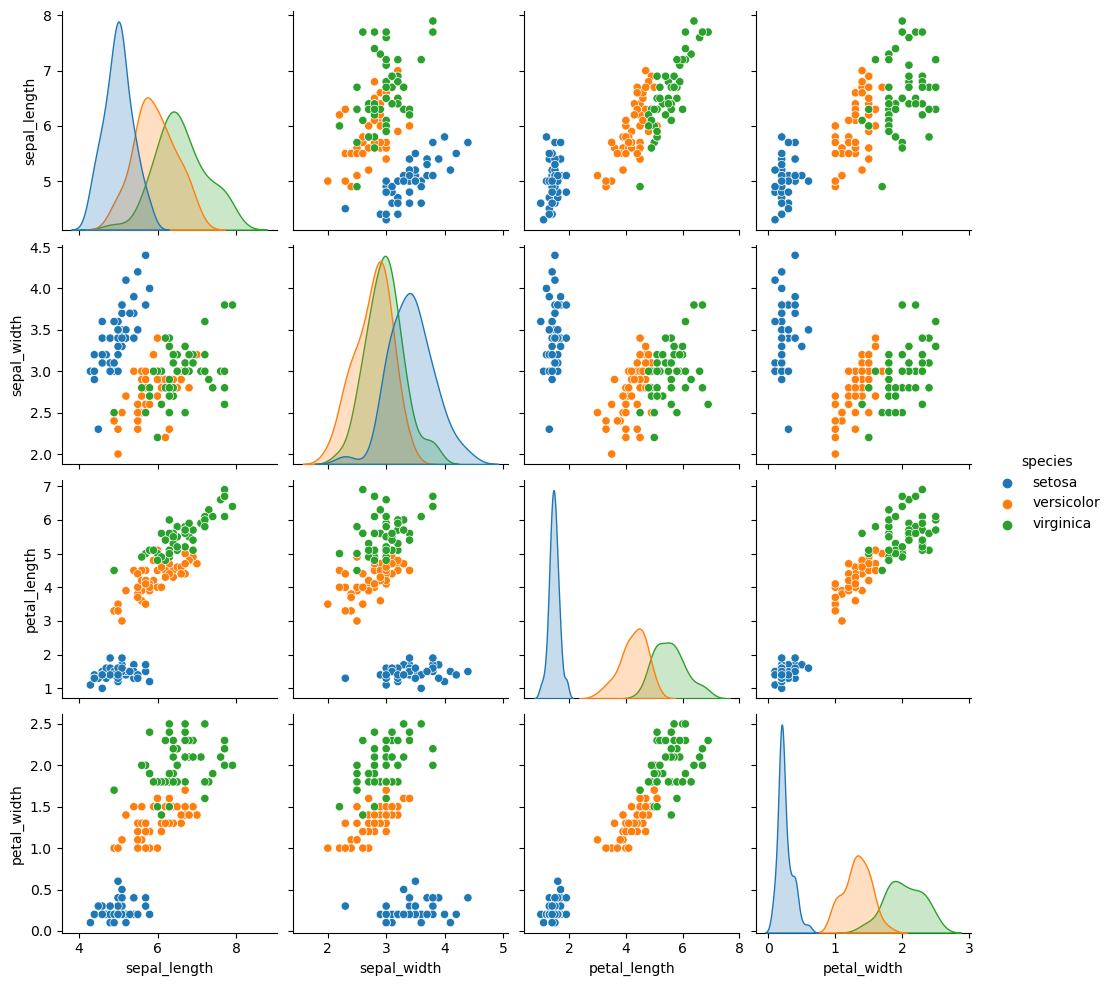

In [3]:
df = sns.load_dataset("iris")

sns.pairplot(df, hue="species", size=2.5)  

plt.show()

In [4]:
x = np.linspace(-5,5,101)

(X,Y) = np.meshgrid(x,x)

In [5]:
# Para obtener valores reproducibles, proporciono un valor semilla

np.random.seed(987654321)   

In [6]:
Z = -5 + 3*X-0.5*Y+np.random.randn(np.shape(X)[0], np.shape(X)[1])

In [8]:
from matplotlib import cm

In [9]:
# Establecer el color

myCmap = cm.GnBu_r

In [11]:
from mpl_toolkits.mplot3d import Axes3D

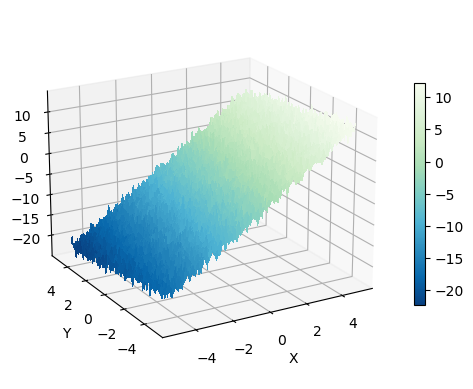

In [15]:
# Grafico

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X,Y,Z, cmap=myCmap, rstride=2, cstride=2, linewidth=0, antialiased=False)

ax.view_init(20,-120)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

fig.colorbar(surf, shrink=0.6)

plt.show()

In [16]:
X.flatten()

array([-5. , -4.9, -4.8, ...,  4.8,  4.9,  5. ])

In [17]:
Y.flatten()

array([-5., -5., -5., ...,  5.,  5.,  5.])

In [18]:
Z.flatten()

array([-15.25344919, -17.84591822, -18.08357699, ...,   6.33209192,
         7.73093668,   6.93390058])

In [21]:
# Convertir los datos en un Pandas DataFrame

df = pd.DataFrame({'x':X.flatten(), 'y':Y.flatten(), 'z':Z.flatten()})

df.head()

,x,y,z
0,-5.0,-5.0,-15.253449
1,-4.9,-5.0,-17.845918
2,-4.8,-5.0,-18.083577
3,-4.7,-5.0,-14.670507
4,-4.6,-5.0,-16.233186


In [22]:
model = smf.ols("z ~ x + y", df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 3.997e+05
Date:                Sat, 12 Aug 2023   Prob (F-statistic):               0.00
Time:                        03:49:46   Log-Likelihood:                -14501.
No. Observations:               10201   AIC:                         2.901e+04
Df Residuals:                   10198   BIC:                         2.903e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9975      0.010   -503.369      0.0

In [23]:
model._results.params

array([-4.99754526,  3.00250049, -0.50514907])

In [26]:
M = np.vstack((np.ones(len(X.flatten())), X.flatten(), Y.flatten())).T
bestfit = np.linalg.lstsq(M,Z.flatten())

C:\Users\usuario\AppData\Local\Temp\ipykernel_768\3441077683.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  bestfit = np.linalg.lstsq(M,Z.flatten())


In [28]:
bestfit

(array([-4.99754526,  3.00250049, -0.50514907]),
 array([10254.10686306]),
 3,
 array([294.46307069, 294.46307069, 101.        ]))

## 12.2.4 Patsy: el lenguaje de fórmulas

El minilenguaje que describe fórmulas

Ej: si tenemos una variable $y$ y queremos hacer una regresión contra otra variable $x$

$y \sim x$

Se asume automáticamente un desplazamiento en el lenguaje de fórmulas. 

Ej: $y$ depende de las variables $x$, $a$, $b$, y la interacción de $a$ y $b$ se puede expresar por

$ y \sim x + a + b + a:b $

http://patsy.readthedocs.org.

|Operador|Significado|
|---|---|
|~|Separa el lado izquierdo del lado derecho. Si se omite, se supone que la fórmula se encuentra solo en el lado derecho|
|+|Combina términos a ambos lados (unión de conjuntos)|
|-|Elimina los términos de la derecha del conjunto de términos de la izquierda (diferencia de conjunto)|
|$*$|$a*b$ es la abreviatura de la expansión a + b + a:b|
|/|a/b es la abreviatura de la expansión a + a:b. Se usa cuando b está anidado dentro de a (por ejemplo, estados y condados)|
|:|Calcula la interacción entre los términos de la izquierda y la derecha|
|$**$|Toma un conjunto de términos a la izquierda y un número entero n a la derecha y calcula el * de ese conjunto de términos consigo mismo n veces|


## 12.2.5 Matriz de diseño

### a) Definición

$ y = f(x,\epsilon) $

$ y = X · \beta + \epsilon $

La matriz X se denomina matriz de diseño del modelo. 

Dado un conjunto de datos $\{y_i, x_{i1},..., x_{ip}\}$    $i=1,...,n$ 

de n unidades estadísticas

Un modelo de regresión lineal asume que la relación entre la variable dependiente $y_i$ y el $p$ vector de regresores $x_i$ es lineal. 

Esta relación se modela a través de 
- Un término de perturbación o variable de error $i$
- Una variable aleatoria no observada que añade ruido a la relación lineal entre la variable dependiente 
- Los regresores. 

$ y_i = \beta_0 + \beta_1 x_{i1} + ... + \beta_p x_{ip} + \epsilon_i = \beta_0 + x_i^T · \beta + \epsilon_i$

donde T denota la transpuesta de manera que xT i · β es el producto interno entre los vectores xi y β. A menudo, estas n ecuaciones se apilan juntas y se escriben en forma vectorial como

$ y = \beta_0 + X · \beta + \epsilon $

donde

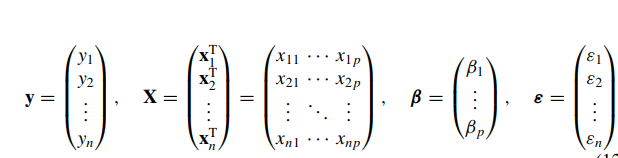

In [24]:
Image(filename = 'Imagenes/formula12.13.png')

$y_i$ 
- Se denomina regresora, variable endógena, variable de respuesta, variable medida o variable dependiente. 
- La decisión sobre qué variable en un conjunto de datos se modela como variable dependiente y cuáles se modelan como variables independientes puede basarse en la presunción de que el valor de una de las variables es causado por las otras variables o directamente influenciado por ellas.
- Puede haber una razón operativa para modelar una de las variables en términos de las otras, en cuyo caso no es necesario que haya presunción de causalidad. 

$x_i$
- Se denominan regresores, variables exógenas, variables explicativas, covariables, variables de entrada, variables predictoras o variables independientes. 

$\beta$
- Es un vector de parámetros p-dimensional. 
- Sus elementos se llaman efectos o coeficientes de regresión. 
- La estimación e inferencia estadística en regresión lineal se centra en $\beta$.

$\epsilon_i$
- Residuos, término de error, término de perturbación o ruido. 
- Captura todos los demás factores que influyen en la variable dependiente $y_i$ distintos de los regresores $x_i$.

Si p = 1 tenemos una regresión lineal simple.

Si i > 1 hablamos de regresión multilineal o regresión lineal múltiple.

### b) Ejemplos: ANOVA de una vía

ANOVA de una vía (modelo de medias de celdas).

3 grupos y 7 observaciones. 

El conjunto de datos dado tiene las primeras tres observaciones pertenecientes al primer grupo, las dos siguientes observaciones pertenecen al segundo grupo, y las dos últimas observaciones son de el tercer grupo. 

Si el modelo a ajustar es solo la media de cada grupo

$ y_{ij} = \mu_i + \epsilon_{ij} $, $i = 1,2,3$

Matricialmente

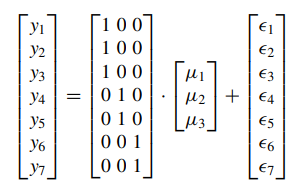

In [25]:
Image(filename = 'Imagenes/formula12.15.png')

$\mu_i$: media del i-ésimo grupo. 

Codificación ficticia de variables (o "codificación en caliente"): Codifica las variables en categóricas u ordinales, donde la presencia/ausencia de cada categoría se indica mediante 0/1-s.

ANOVA de una vía (compensación del grupo de referencia)

ANOVA puede ser escrito como cada parámetro de grupo $\tau_i$ siendo un desplazamiento de algún referencia. 

Este punto de referencia se toma como uno de los grupos bajo consideración. 

Tiene sentido en el contexto de comparar múltiples grupos de tratamiento a un grupo de control, y el grupo de control se considera la "referencia". 

Ej: se eligió el grupo 1 como grupo de referencia. 

$ y_{ij} = \mu + \tau_i + \epsilon_{ij} $, $i = 1,2,3$

con  $\tau_i = 0$

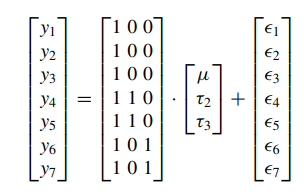

In [26]:
Image(filename = 'Imagenes/formula12.17.png')

$\mu$: media del grupo de referencia 

$\tau_i$: diferencia del grupo $i$ con respecto al grupo de referencia

$\tau_1$ no se incluye en la matriz porque su diferencia con el grupo de referencia (en sí) es necesariamente cero.

# 12.3 Análisis de regresión lineal con Python

## 12.3.1 Ejemplo 1: ajuste de línea con intervalos de confianza

Para distribuciones univariadas, 
- Los IC del 95 % basados en la desviación estándar: indican el intervalo que esperamos que contenga el 95 % de los datos
- Los IC basados en el error estándar de la media: indican el intervalo que contiene la media verdadera con 95% de probabilidad.

Tipos de IC para los ajustes de recta
- Para los datos
- Para los parámetros ajustados

In [24]:
x = np.array([15.3, 10.8, 8.1, 19.5, 7.2, 5.3, 9.3, 11.1, 7.5, 12.2,
              6.7, 5.2, 19.0, 15.1, 6.7, 8.6, 4.2, 10.3, 12.5, 16.1,
              13.3, 4.9, 8.8, 9.5])

y = np.array([1.76, 1.34, 1.27, 1.47, 1.27, 1.49, 1.31, 1.09, 1.18,
              1.22, 1.25, 1.19, 1.95, 1.28, 1.52, np.nan, 1.12, 1.37,
              1.19, 1.05, 1.32, 1.03, 1.12, 1.70])

In [25]:
goodIndex = np.invert(np.logical_or(np.isnan(x), np.isnan(y)))
goodIndex 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True])

In [26]:
x = x[goodIndex]
y = y[goodIndex]

In [27]:
n = len(x)
n

23

In [28]:
Sxx = np.sum(x**2) - np.sum(x)**2/n
Sxx

429.7043478260871

In [29]:
Syy = np.sum(y**2) - np.sum(y)**2/n    
Syy

1.193365217391289

In [30]:
Sxy = np.sum(x*y) - np.sum(x)*np.sum(y)/n
Sxy

9.437391304347784

In [31]:
mean_x = np.mean(x)
mean_x

10.373913043478263

In [32]:
mean_y = np.mean(y)
mean_y

1.3256521739130438

In [33]:
# Ajuste de la recta
b = Sxy/Sxx
a = mean_y - b*mean_x

In [34]:
a,b

(1.0978148777723828, 0.021962522259996658)

In [35]:
# Residuales
fit = lambda xx: a + b*xx
residuals = y - fit(x)

var_res = np.sum(residuals**2)/(n-2)
sd_res = np.sqrt(var_res)

In [36]:
residuals

array([ 0.32615853,  0.00498988, -0.00571131, -0.05608406,  0.01405496,
        0.27578375,  0.00793367, -0.25159887, -0.08253379, -0.14575765,
        0.00503622, -0.02201999,  0.4348972 , -0.14944896,  0.27503622,
       -0.07005747,  0.04597114, -0.18234641, -0.40141149, -0.06991642,
       -0.17543124, -0.17108507,  0.39354116])

In [37]:
var_res

0.0469569667044412

In [38]:
sd_res

0.21669556226291575

In [39]:
# IC

se_b = sd_res/np.sqrt(Sxx)
se_a = sd_res*np.sqrt(np.sum(x**2)/(n*Sxx))

alpha = 0.05
df = n-2                            # grados de libertad
tval = stats.t.isf(alpha/2, df)     # valor t 

ci_a = a + tval*se_a*np.array([-1,1])
ci_b = b + tval*se_b*np.array([-1,1])    

In [40]:
ci_a, ci_b

(array([0.85349938, 1.34213037]), array([0.00022311, 0.04370194]))

In [41]:
# Crear series de nuevos valores x de prueba para predecir
npts = 100
px = np.linspace(np.min(x), np.max(x), num=npts)

se_fit = lambda x: sd_res * np.sqrt(  1./n + (x-mean_x)**2/Sxx)
se_predict = lambda x: sd_res * np.sqrt(1+1./n + (x-mean_x)**2/Sxx)

In [42]:
print(f'Resumen: a={a:5.4f}+/-{tval*se_a:5.4f}, b={b:5.4f}+/-{tval*se_b:5.4f}\n')
print(f'IC: ci_a=({ci_a[0]:5.4f} - {ci_a[1]:5.4f}), ci_b=({ci_b[0]:5.4f} - {ci_b[1]:5.4f})\n')
print(f'Residuales: Varianza = {var_res:5.4f}, Desviación estándard = {sd_res:5.4f}\n')
print(f'Alpha = {alpha:.3f}, Valor t = {tval:5.4f}, Grados de libertad = {df:d}')

Resumen: a=1.0978+/-0.2443, b=0.0220+/-0.0217

IC: ci_a=(0.8535 - 1.3421), ci_b=(0.0002 - 0.0437)

Residuales: Varianza = 0.0470, Desviación estándard = 0.2167

Alpha = 0.050, Valor t = 2.0796, Grados de libertad = 21


In [43]:
# Return info
ri = {'residuals': residuals,
      'var_res': var_res,
      'sd_res': sd_res,
      'alpha': alpha,
      'tval': tval,
      'df': df}

ri

{'residuals': array([ 0.32615853,  0.00498988, -0.00571131, -0.05608406,  0.01405496,
         0.27578375,  0.00793367, -0.25159887, -0.08253379, -0.14575765,
         0.00503622, -0.02201999,  0.4348972 , -0.14944896,  0.27503622,
        -0.07005747,  0.04597114, -0.18234641, -0.40141149, -0.06991642,
        -0.17543124, -0.17108507,  0.39354116]),
 'var_res': 0.0469569667044412,
 'sd_res': 0.21669556226291575,
 'alpha': 0.05,
 'tval': 2.0796138447276626,
 'df': 21}

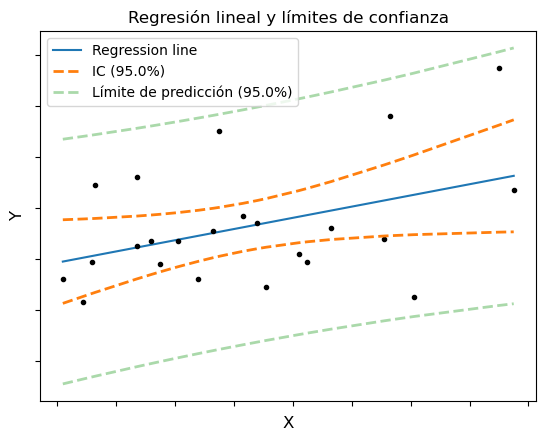

In [44]:
# Grafico los datos
plt.figure()
plt.plot(px, fit(px),color='C0', label='Regression line')
#plt.plot(x,y,'k.', label='Sample observations', ms=10)
plt.plot(x,y,'k.')

x.sort()
limit = (1-alpha)*100
plt.plot(x, fit(x)+tval*se_fit(x),
         ls='--',
         color='C1',
         lw=2,
         label = f'IC ({limit:.1f}%)' )

plt.plot(x, fit(x)-tval*se_fit(x),
         ls='--',
         color='C1',
         lw=2 )

plt.plot(x, fit(x)+tval*se_predict(x),
         ls='--',
         lw=2,
         color='C2', alpha=0.4,     #(0.2,1,0.2)
         label = f'Límite de predicción ({limit:.1f}%)' )

plt.plot(x, fit(x)-tval*se_predict(x),
         ls='--',
         lw=2,
         color='C2', alpha=0.4)

plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('Regresión lineal y límites de confianza', fontsize=12)

# Leyenda
plt.legend(loc=0)
ax = plt.gca()
leg = ax.get_legend()
ax.set_xticklabels([])
ax.set_yticklabels([])
ltext = leg.get_texts()
plt.setp(ltext, fontsize=10)

plt.show()

In [45]:
newx=np.array([1,4.5])

In [55]:
if len(newx)>0:
    try:
        newx.size
    except AttributeError:
        newx = np.array([newx])

    print(f'Example: x = {newx[0]} +/- {tval*se_predict(newx[0])} => se_fit = {se_fit(newx[0])}, se_predict = {se_predict(newx[0]):6.5f}\n' )

    newy = (fit(newx),
            fit(newx) - se_predict(newx),
            fit(newx) + se_predict(newx) )
    print((a,b,(ci_a, ci_b), ri, newy))
else:
    print((a,b,(ci_a, ci_b), ri))

Example: x = 1.0 +/- 0.5034246642087405 => se_fit = 0.10790661596647662, se_predict = 0.24208

(1.0978148777723828, 0.021962522259996658, (array([0.85349938, 1.34213037]), array([0.00022311, 0.04370194])), {'residuals': array([ 0.32615853,  0.00498988, -0.00571131, -0.05608406,  0.01405496,
        0.27578375,  0.00793367, -0.25159887, -0.08253379, -0.14575765,
        0.00503622, -0.02201999,  0.4348972 , -0.14944896,  0.27503622,
       -0.07005747,  0.04597114, -0.18234641, -0.40141149, -0.06991642,
       -0.17543124, -0.17108507,  0.39354116]), 'var_res': 0.0469569667044412, 'sd_res': 0.21669556226291575, 'alpha': 0.05, 'tval': 2.0796138447276626, 'df': 21}, (array([1.1197774 , 1.19664623]), array([0.87770137, 0.96693128]), array([1.36185343, 1.42636117])))


## 12.3.2 Ejemplo 2: polinomio cuadrático ruidoso

Ajustar una curva ruidosa, ligeramente cuadrática. 

In [56]:
# Genere un conjunto de datos ruidoso, ligeramente cuadrático
x = np.arange(100)
y = 150 + 3*x + 0.03*x**2 + 5*np.random.randn(len(x))

In [58]:
# Crear las Matrices de Diseño
M1 = np.column_stack( (np.ones_like(x), x) )
M2 = np.column_stack( (np.ones_like(x), x, x**2) )
M3 = np.column_stack( (np.ones_like(x), x, x**2, x**3))

# una solución alternativa equivalente
# con statsmodels sería

M1 = sm.add_constant(x)

In [59]:
M1

array([[ 1,  0],
       [ 1,  1],
       [ 1,  2],
       [ 1,  3],
       [ 1,  4],
       [ 1,  5],
       [ 1,  6],
       [ 1,  7],
       [ 1,  8],
       [ 1,  9],
       [ 1, 10],
       [ 1, 11],
       [ 1, 12],
       [ 1, 13],
       [ 1, 14],
       [ 1, 15],
       [ 1, 16],
       [ 1, 17],
       [ 1, 18],
       [ 1, 19],
       [ 1, 20],
       [ 1, 21],
       [ 1, 22],
       [ 1, 23],
       [ 1, 24],
       [ 1, 25],
       [ 1, 26],
       [ 1, 27],
       [ 1, 28],
       [ 1, 29],
       [ 1, 30],
       [ 1, 31],
       [ 1, 32],
       [ 1, 33],
       [ 1, 34],
       [ 1, 35],
       [ 1, 36],
       [ 1, 37],
       [ 1, 38],
       [ 1, 39],
       [ 1, 40],
       [ 1, 41],
       [ 1, 42],
       [ 1, 43],
       [ 1, 44],
       [ 1, 45],
       [ 1, 46],
       [ 1, 47],
       [ 1, 48],
       [ 1, 49],
       [ 1, 50],
       [ 1, 51],
       [ 1, 52],
       [ 1, 53],
       [ 1, 54],
       [ 1, 55],
       [ 1, 56],
       [ 1, 57],
       [ 1, 58

In [60]:
M2

array([[   1,    0,    0],
       [   1,    1,    1],
       [   1,    2,    4],
       [   1,    3,    9],
       [   1,    4,   16],
       [   1,    5,   25],
       [   1,    6,   36],
       [   1,    7,   49],
       [   1,    8,   64],
       [   1,    9,   81],
       [   1,   10,  100],
       [   1,   11,  121],
       [   1,   12,  144],
       [   1,   13,  169],
       [   1,   14,  196],
       [   1,   15,  225],
       [   1,   16,  256],
       [   1,   17,  289],
       [   1,   18,  324],
       [   1,   19,  361],
       [   1,   20,  400],
       [   1,   21,  441],
       [   1,   22,  484],
       [   1,   23,  529],
       [   1,   24,  576],
       [   1,   25,  625],
       [   1,   26,  676],
       [   1,   27,  729],
       [   1,   28,  784],
       [   1,   29,  841],
       [   1,   30,  900],
       [   1,   31,  961],
       [   1,   32, 1024],
       [   1,   33, 1089],
       [   1,   34, 1156],
       [   1,   35, 1225],
       [   1,   36, 1296],
 

In [61]:
M3

array([[     1,      0,      0,      0],
       [     1,      1,      1,      1],
       [     1,      2,      4,      8],
       [     1,      3,      9,     27],
       [     1,      4,     16,     64],
       [     1,      5,     25,    125],
       [     1,      6,     36,    216],
       [     1,      7,     49,    343],
       [     1,      8,     64,    512],
       [     1,      9,     81,    729],
       [     1,     10,    100,   1000],
       [     1,     11,    121,   1331],
       [     1,     12,    144,   1728],
       [     1,     13,    169,   2197],
       [     1,     14,    196,   2744],
       [     1,     15,    225,   3375],
       [     1,     16,    256,   4096],
       [     1,     17,    289,   4913],
       [     1,     18,    324,   5832],
       [     1,     19,    361,   6859],
       [     1,     20,    400,   8000],
       [     1,     21,    441,   9261],
       [     1,     22,    484,  10648],
       [     1,     23,    529,  12167],
       [     1, 

In [63]:
# Resuelvo las ecuaciones
p1 = np.linalg.lstsq(M1, y, rcond=-1)
p2 = np.linalg.lstsq(M2, y, rcond=-1)
p3 = np.linalg.lstsq(M3, y, rcond=-1)

In [64]:
p1

(array([100.82818337,   5.96967289]),
 array([56246.3820628]),
 2,
 array([573.08343972,   5.03697508]))

In [65]:
p2

(array([1.51234869e+02, 2.88354929e+00, 3.11729656e-02]),
 array([2287.05155185]),
 3,
 array([4.41660641e+04, 1.43349989e+02, 3.39747644e+00]))

In [66]:
p3

(array([1.50550900e+02, 2.96859857e+00, 2.90144283e-02, 1.45356049e-05]),
 array([2279.51626197]),
 4,
 array([3.71384041e+06, 7.36218662e+03, 5.74298789e+01, 2.58697200e+00]))

In [67]:
np.set_printoptions(precision=2)
print(f'Los coeficientes del ajuste lineal {p1[0]}\n')
print(f'Los coeficientes del ajuste cuadrático: {p2[0]}\n')
print(f'Los coeficientes del ajuste cúbico: {p3[0]}')

Los coeficientes del ajuste lineal [100.83   5.97]

Los coeficientes del ajuste cuadrático: [1.51e+02 2.88e+00 3.12e-02]

Los coeficientes del ajuste cúbico: [1.51e+02 2.97e+00 2.90e-02 1.45e-05]


In [68]:
# Solución con statsmodels
Res1 = sm.OLS(y, M1).fit()
Res2 = sm.OLS(y, M2).fit()
Res3 = sm.OLS(y, M3).fit()

In [69]:
print(Res1.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.981   
Dependent Variable: y                AIC:                921.0204
Date:               2023-08-01 00:27 BIC:                926.2307
No. Observations:   100              Log-Likelihood:     -458.51 
Df Model:           1                F-statistic:        5174.   
Df Residuals:       98               Prob (F-statistic): 1.27e-86
R-squared:          0.981            Scale:              573.94  
-------------------------------------------------------------------
         Coef.     Std.Err.      t      P>|t|     [0.025    0.975] 
-------------------------------------------------------------------
const   100.8282     4.7557   21.2015   0.0000   91.3906   110.2657
x1        5.9697     0.0830   71.9290   0.0000    5.8050     6.1344
-----------------------------------------------------------------
Omnibus:               12.137       Durbin-Watson:          0.083
Prob(Omnibus):   

In [71]:
print(Res2.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.999    
Dependent Variable: y                AIC:                602.7726 
Date:               2023-08-01 00:28 BIC:                610.5881 
No. Observations:   100              Log-Likelihood:     -298.39  
Df Model:           2                F-statistic:        6.412e+04
Df Residuals:       97               Prob (F-statistic): 4.03e-152
R-squared:          0.999            Scale:              23.578   
-------------------------------------------------------------------
            Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
const      151.2349    1.4281  105.9027  0.0000  148.4006  154.0692
x1           2.8835    0.0667   43.2525  0.0000    2.7512    3.0159
x2           0.0312    0.0007   47.8389  0.0000    0.0299    0.0325
------------------------------------------------------------------
Omnibus

In [72]:
print(Res3.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.999    
Dependent Variable: y                AIC:                604.4425 
Date:               2023-08-01 00:28 BIC:                614.8632 
No. Observations:   100              Log-Likelihood:     -298.22  
Df Model:           3                F-statistic:        4.244e+04
Df Residuals:       96               Prob (F-statistic): 9.84e-150
R-squared:          0.999            Scale:              23.745   
--------------------------------------------------------------------
         Coef.     Std.Err.      t      P>|t|     [0.025     0.975] 
--------------------------------------------------------------------
const   150.5509     1.8783   80.1534   0.0000   146.8225   154.2793
x1        2.9686     0.1651   17.9768   0.0000     2.6408     3.2964
x2        0.0290     0.0039    7.4642   0.0000     0.0213     0.0367
x3        0.0000     0.0000    0.5633   0.5745    -0.0000     0.0001

In [74]:
print(f'El valor AIC es {Res1.aic:4.1f} para el ajuste lineal,\n' +\
    f'{Res2.aic:4.1f} para el ajuste cuadrático, y \n' +\
    f'{Res3.aic:4.1f} para el ajuste cúbico')

El valor AIC es 921.0 para el ajuste lineal,
602.8 para el ajuste cuadrático, y 
604.4 para el ajuste cúbico


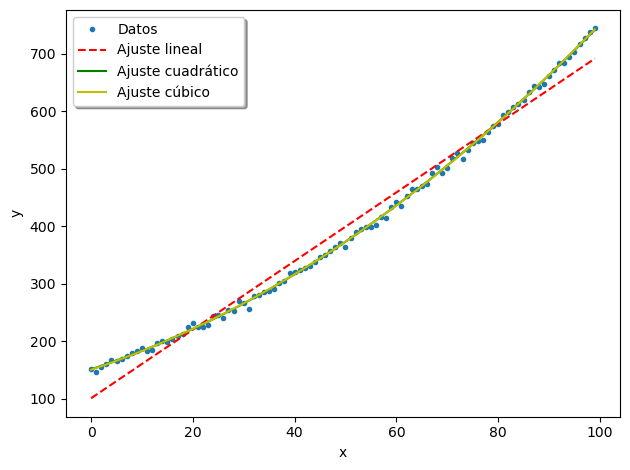

In [75]:
# Gráfico
plt.plot(x,y, '.', label='Datos')
plt.plot(x, Res1.fittedvalues, 'r--', label='Ajuste lineal')
plt.plot(x, Res2.fittedvalues, 'g', label='Ajuste cuadrático')
plt.plot(x, Res3.fittedvalues, 'y', label='Ajuste cúbico')

plt.legend(loc='upper left', shadow=True)
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()

plt.show()

Criterio de información de Akaike: evalúa la calidad del modelo.

Cuanto menor sea el valor AIC, mejor será el modelo.
 
El modelo cuadrático tiene el valor AIC más bajo y por lo tanto es el mejor modelo: proporciona la misma calidad de ajuste que el modelo cúbico pero utiliza menos parámetros para lograr esa calidad. 

In [76]:
df = pd.DataFrame({'x':x, 'y':y})
df.head()

,x,y
0,0,152.131825
1,1,146.945097
2,2,154.808922
3,3,159.751460
4,4,167.464670


In [77]:
Res1F = smf.ols('y~x', df).fit()
print(Res1F.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     5174.
Date:                Tue, 01 Aug 2023   Prob (F-statistic):           1.27e-86
Time:                        00:39:35   Log-Likelihood:                -458.51
No. Observations:                 100   AIC:                             921.0
Df Residuals:                      98   BIC:                             926.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    100.8282      4.756     21.202      0.0

In [78]:
Res2F = smf.ols('y ~ x+I(x**2)', df).fit()
print(Res2F.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 6.412e+04
Date:                Tue, 01 Aug 2023   Prob (F-statistic):          4.03e-152
Time:                        00:39:52   Log-Likelihood:                -298.39
No. Observations:                 100   AIC:                             602.8
Df Residuals:                      97   BIC:                             610.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    151.2349      1.428    105.903      0.0

In [79]:
Res3F = smf.ols('y ~ x+I(x**2)+I(x**3)', df).fit()
print(Res3F.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.244e+04
Date:                Tue, 01 Aug 2023   Prob (F-statistic):          9.84e-150
Time:                        00:40:04   Log-Likelihood:                -298.22
No. Observations:                 100   AIC:                             604.4
Df Residuals:                      96   BIC:                             614.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    150.5509      1.878     80.153      0.0

In [80]:
Res1F.params

Intercept    100.828183
x              5.969673
dtype: float64

In [81]:
Res2F.params

Intercept    151.234869
x              2.883549
I(x ** 2)      0.031173
dtype: float64

In [82]:
Res3F.params

Intercept    150.550900
x              2.968599
I(x ** 2)      0.029014
I(x ** 3)      0.000015
dtype: float64

In [83]:
Res1F.bse

Intercept    4.755707
x            0.082994
dtype: float64

In [84]:
Res2F.bse

Intercept    1.428055
x            0.066668
I(x ** 2)    0.000652
dtype: float64

In [85]:
Res3F.bse

Intercept    1.878284
x            0.165135
I(x ** 2)    0.003887
I(x ** 3)    0.000026
dtype: float64

In [86]:
Res1F.conf_int()

,0,1
Intercept,91.390637,110.265730
x,5.804974,6.134372


In [87]:
Res2F.conf_int()

,0,1
Intercept,148.400576,154.069162
x,2.751232,3.015866
I(x ** 2),0.029880,0.032466


In [88]:
Res3F.conf_int()

,0,1
Intercept,146.822536,154.279265
x,2.640807,3.296390
I(x ** 2),0.021299,0.036730
I(x ** 3),-0.000037,0.000066


# 12.4 Resultados del modelo de modelos de regresión lineal

## 12.4.1 Ejemplo: Tabaco y alcohol en el Reino Unido

Datos de la biblioteca DASL

(https://dasl.data description.com/datafile/tobacco-and-alcohol)

con respecto a la correlación entre las compras de tabaco y alcohol en diferentes regiones del Reino Unido. 

La característica interesante de este conjunto de datos es que Irlanda del Norte se reporta como un caso atípico. 

In [2]:
data_str = """Region Alcohol Tobacco
North 6.47 4.03
Yorkshire 6.13 3.76
Northeast 6.19 3.77
East_Midlands 4.89 3.34
West_Midlands 5.63 3.47
East_Anglia 4.52 2.92
Southeast 5.89 3.20
Southwest 4.79 2.71
Wales 5.27 3.53
Scotland 6.08 4.51
Northern_Ireland 4.02 4.56"""

data_str

'Region Alcohol Tobacco\nNorth 6.47 4.03\nYorkshire 6.13 3.76\nNortheast 6.19 3.77\nEast_Midlands 4.89 3.34\nWest_Midlands 5.63 3.47\nEast_Anglia 4.52 2.92\nSoutheast 5.89 3.20\nSouthwest 4.79 2.71\nWales 5.27 3.53\nScotland 6.08 4.51\nNorthern_Ireland 4.02 4.56'

In [3]:
from io import StringIO
df = pd.read_csv(StringIO(data_str), delim_whitespace=True)
df.head()

,Region,Alcohol,Tobacco
0,North,6.47,4.03
1,Yorkshire,6.13,3.76
2,Northeast,6.19,3.77
3,East_Midlands,4.89,3.34
4,West_Midlands,5.63,3.47


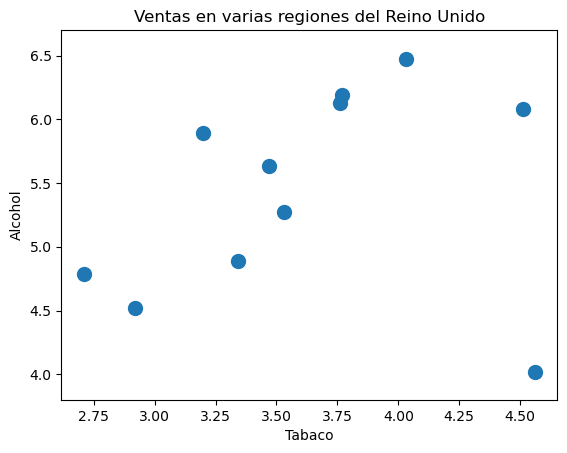

In [4]:
# Gráfico
plt.plot(df.Tobacco, df.Alcohol, 'o', ms=10)

plt.xlabel('Tabaco')
plt.ylabel('Alcohol')
plt.title('Ventas en varias regiones del Reino Unido')
plt.ylim([3.8, 6.7])

plt.show()

In [5]:
result = smf.ols('Alcohol ~ Tobacco', df[:-1]).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                Alcohol   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     12.78
Date:                Tue, 01 Aug 2023   Prob (F-statistic):            0.00723
Time:                        16:58:46   Log-Likelihood:                -4.9998
No. Observations:                  10   AIC:                             14.00
Df Residuals:                       8   BIC:                             14.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0412      1.001      2.038      0.0

C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Se agrega automáticamente una intercepción.

## 12.4.2 Características del modelo

### a) Grados de libertad

Los grados de libertad (Df) del modelo: número de variables predictoras o explicativas. 

Df de los residuos: es el número de observaciones menos los grados de libertad del modelo, menos uno (para el desplazamiento). 

n: número de observaciones

k: número de parámetros de regresión. 

Ej: ajusta una línea recta, k = 2. 

$ y^i $: valores del modelo ajustado

$ \bar{y} $: media

Modelo (corregido) de grados de libertad: 
- DFmod = k − 1
- El “-1” viene del hecho de que sólo estamos interesados en la correlación, no en el absoluto desplazamiento de los datos.

Grados de Libertad Residuales: DFres = n − k 

Total de grados de libertad (corregidos): DFtot = n − 1
- La linea horizontal la regresión es el modelo de hipótesis nula. 

Para modelos de regresión múltiple con intersección,DFmod + DFres = DFtot. 

Media de los cuadrados del modelo: MSmod = SSmod/DFmod 

Media de cuadrados de residuos: 
- MSres = SSres/DFres 
- Es una estimación imparcial para $\sigma^2$ para modelos de regresión múltiple. 

Media total de cuadrados:
- MStot = SStot/DFtot
- Es la varianza muestral de la variable y.

### b) El valor $R^2$

Indica la proporción de variación en la variable y que se debe a la variación en las variables x. 

Para la regresión lineal simple
- $R^2$ es el cuadrado de la correlación muestral $r_{xy}$.

Para la regresión lineal múltiple con intercepto (incluye regresión lineal simple)

- $ R^2 = \frac{SS_{mod}}{SS_{tot}} $

### c) $\bar{R}^2$. El valor $R^2$ ajustado

$\bar{R}^2$

$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} $

$ 1 - R^2 = \frac{SS_{res}}{SS_{tot}} $

$ 1 - \bar{R}^2 = \frac{Varianza Residual}{Varianza Total} $

Varianza residual (muestra): SSres/DFres = SSres/(n − k)

Varianza total (muestra): SStot/DFtot = SStot/(n − 1). 

$ 1 - \bar{R}^2 = \frac{\frac{SS_{res}}{n-k}}{\frac{SS_{tot}}{n-1}} $

$ 1 - \bar{R}^2 = \frac{SS_{res}}{SS_{tot}} \frac{n-1}{n-k} $

$ \bar{R}^2 = 1 - \frac{SS_{res}}{SS_{tot}} \frac{n-1}{n-k} $

$ \bar{R}^2 = 1 - (1 - R^2) \frac{n-1}{n-k} $

### d) La prueba F

Para un modelo de regresión múltiple con intercepto,

$Y_j = \alpha  + \beta_1 X_{1j} + ... + \beta_n X_{nj} + \epsilon_i$

$Y_j = \alpha + \sum\limits_{i=1}^{n} \beta_i X_{ij} + \epsilon_j$

$Y_j = E(Y_j|X) + \epsilon_j$

$E(Y_j|X)$: valor esperado para Y, dado X. 

Hipótesis nula ($ H_0 $): $ \beta_1 = \beta_2 = ... = \beta_n = 0 $

Hipótesis alternativa ($ H_1 $): $\beta_j \neq 0$, para al menos un valor de $j$

Se conoce como la prueba F general para regresión. 

Si $t_1, t_2, ..., t_m$ son variables aleatorias independientes, $N(0, \sigma^2)$, entonces $\sum\limits_{i=1}^{m} \frac{t^2}{\sigma^2}$ es una variable aleatoria $\chi^2$ (chi-cuadrado) con $m$ grados de libertad. 

Si $H_0$ es verdadera y los residuos no están sesgados, son homocedásticos (todos los valores de la función tienen la misma varianza), independientes y normales, entonces:

1. $\frac{SS_{res}}{\sigma^2}$ tiene una distribución $\chi^2$ con $DF_{res}$ grados de libertad. 

2. $\frac{SS_{mod}}{\sigma^2}$ tiene una distribución $\chi^2$ con $DF_{mod}$ grados de libertad. 

3. $SS_{res}$ y $SS_{mod}$ son variables aleatorias independientes. 

Si
- $u$ es una variable aleatoria $\chi^2$ con $n$ grados de libertad
- $v$ es una variable aleatoria $\chi^2$ con $m$ grados de libertad
- $u$ y $v$ son independientes

entonces 

$ F = \frac{\frac{u}{n}}{\frac{v}{m}}$ tiene una distribución F con ($n, m$) grados de libertad. 

Si $H_0$ es verdadera

$ F = \frac{(SS_{mod}/\sigma^2)/DF_{mod}}{(SS_{res}/\sigma^2)/DF_{res}} $

$ F = \frac{SS_{mod}/DF_{mod}}{SS_{res}/DF_{res}} $

$ F = \frac{MS_{mod}}{MS_{res}} $

tiene una distribución F con ($DF_{mod}$, $DF_{res}$) grados de libertad, y es independiente de $\sigma$. 

In [6]:
N = result.nobs
N

10.0

In [7]:
k = result.df_model + 1
k

2.0

In [8]:
dfm = k-1
dfm

1.0

In [9]:
dfe = N - k
dfe

8.0

In [10]:
F = result.mse_model / result.mse_resid
F

12.784975818025687

In [11]:
p = 1.0 - stats.f.cdf(F,dfm,dfe)
p

0.007234358351729475

In [12]:
print(f'Estadístico F: {F:.3f}\nValor p: {p:.5f}.')

Estadístico F: 12.785
Valor p: 0.00723.


Calculamos la cfd de la distribución F con parámetros $m = k-1 = 1$, y $n=N-k=8$, hasta el estadístico F. 

Restamos esta cantidad por uno, obteniendo la probabilidad en la cola, que representa la probabilidad de observar estadísticos F más extremos que el observado.

### e) Función Log-Verosimilitud

En el enfoque MCO el modelo es constante y los errores de respuesta son variables.

En el enfoque de máxima verosimilitud los valores de respuesta de los datos se consideran constantes y se maximiza la verosimilitud del modelo. 

Para el modelo de regresión lineal clásico (con errores normales) tenemos

$ \epsilon = y_i - \sum\limits_{k=1}^{n} \beta_k x_{ik} = y_i - \hat{y_i} $    $ \in N(0,\sigma)$

Densidad de probabilidad

$ p(\epsilon_i) = \varPhi (\frac{y_i - \hat{y_i}}{\sigma}) $

$\varPhi(z)$: función de distribución de probabilidad normal estándar. 

La probabilidad de muestras independientes es el producto de las probabilidades individuales

$ \Pi_{total} = \Pi_{i=1}^n p(\epsilon_i)$

Función Log Likelihood

$ ln(L) = ln(\Pi_{total}) $

$ ln(L) = ln [ \Pi_{i=1}^n \frac{1}{\sigma \sqrt{2\pi}} exp(- \frac{(y_i - \hat{y_i})^2}{2\sigma^2}) ] $

$ ln(L) = \sum\limits_{i=1}^{n} [ ln (\frac{1}{\sigma \sqrt{2\pi}}) - (\frac{(y_i - \hat{y_i})^2}{2\sigma^2}) ] $

Estimador de máxima verosimilitud de $\sigma^2$

$ E(\sigma^2) = \frac{SS_{res}}{n} $

In [13]:
N = result.nobs
N

10.0

In [14]:
SSR = result.ssr
SSR

1.5914726237647399

In [15]:
sigma2 = SSR / N
sigma2

0.15914726237647397

In [16]:
L = (1.0 / np.sqrt(2 * np.pi * sigma2)) ** N * np.exp(-SSR / (2 * sigma2))
L

0.00673957307949032

In [17]:
lnL = np.log( L )
print(f'ln(L) = {lnL}')

ln(L) = -4.999758697385978


### f) Contenido de la Información de los Modelos Estadísticos—AIC y BIC

Para juzgar la calidad de un modelo

Se deben inspeccionar visualmente los residuos. 

Se puede utilizar una serie de criterios numéricos para evaluar la calidad de un modelo estadístico. 

Estos criterios representan varios enfoques para equilibrar la precisión del modelo con la parsimonia. 

Ej: 
- El valor R2 ajustado, que, en contraste con el valor R2, disminuye si hay demasiados regresores en el modelo. 
- Criterio de Información de Akaike (AIC) 
- Criterio de Información de Schwartz o Bayesiano (BIC)

Los 2 últimos se basan en la probabilidad logarítmica. 

Ambas medidas introducen una penalización por la complejidad del modelo, pero el AIC penaliza la complejidad con menos severidad que el BIC. 

Criterio de información de Akaike AIC 

$ AIC = 2 * k - 2 * ln(L) $

Criterio de información bayesiano o Schwartz BIC 

$ BIC = k ∗ ln(N) − 2 ∗ ln(L)$

N: número de observaciones

k: número de parámetros 

L: probabilidad. 

Tenemos dos parámetros en este ejemplo, la pendiente y la intersección. 

El AIC es una estimación relativa de la pérdida de información entre diferentes modelos. 

El BIC se propuso inicialmente utilizando un argumento bayesiano y no se relaciona con ideas de información. 

Ambas medidas solo se utilizan cuando se trata de decidir entre diferentes modelos. 

Si tenemos una regresión para las ventas de alcohol basada en las ventas de cigarrillos y otro modelo para el consumo de alcohol que incorporó las ventas de cigarrillos y las ventas de encendedores, entonces debemos elegir el modelo con el valor AIC o BIC más bajo.

## 12.4.3 Coeficientes del modelo y su interpretación

### a) Coeficientes

In [18]:
result.params

Intercept    2.041223
Tobacco      1.005896
dtype: float64

$ \beta = (X^T · X)^{-1}X^T·y $

$X$: matriz de diseño (matriz de variables predictoras como columnas, con una columna extra de unos para el término constante)

$y$: vector columna de la variable de respuesta

$\beta$: vector columna de coeficientes correspondientes a las columnas de $X$

In [19]:
df['Unos'] = np.ones(len(df))

In [20]:
df

,Region,Alcohol,Tobacco,Unos
0,North,6.47,4.03,1.0
1,Yorkshire,6.13,3.76,1.0
2,Northeast,6.19,3.77,1.0
3,East_Midlands,4.89,3.34,1.0
4,West_Midlands,5.63,3.47,1.0
5,East_Anglia,4.52,2.92,1.0
6,Southeast,5.89,3.20,1.0
7,Southwest,4.79,2.71,1.0
8,Wales,5.27,3.53,1.0
9,Scotland,6.08,4.51,1.0


In [21]:
Y = df.Alcohol[:-1]
Y

0    6.47
1    6.13
2    6.19
3    4.89
4    5.63
5    4.52
6    5.89
7    4.79
8    5.27
9    6.08
Name: Alcohol, dtype: float64

In [22]:
X = df[['Tobacco','Unos']][:-1]
X

,Tobacco,Unos
0,4.03,1.0
1,3.76,1.0
2,3.77,1.0
3,3.34,1.0
4,3.47,1.0
5,2.92,1.0
6,3.20,1.0
7,2.71,1.0
8,3.53,1.0
9,4.51,1.0


El "-1" en los índices excluye el último punto de datos, el valor atípico de Irlanda del Norte.

### b) Error estándar

Para obtener los errores estándar de los coeficientes calcularemos la matriz de covarianza (o matriz de varianza de covarianza) para los coeficientes estimados $\beta$ de las variables predictoras.

$ C = cov(\beta) = \sigma^2 (X^T · X)^{-1}  $

$ \sigma^2 $: varianza o error cuadrático medio de los residuos. 

Los errores estándar son las raíces cuadradas de los elementos en la diagonal principal de esta matriz de covarianza. 

In [23]:
X = df.Tobacco[:-1]
X

0    4.03
1    3.76
2    3.77
3    3.34
4    3.47
5    2.92
6    3.20
7    2.71
8    3.53
9    4.51
Name: Tobacco, dtype: float64

In [24]:
# Agregue una columna de unos para el término de intersección constante
X = np.column_stack((np.ones_like(X), X))
X

array([[1.  , 4.03],
       [1.  , 3.76],
       [1.  , 3.77],
       [1.  , 3.34],
       [1.  , 3.47],
       [1.  , 2.92],
       [1.  , 3.2 ],
       [1.  , 2.71],
       [1.  , 3.53],
       [1.  , 4.51]])

In [25]:
# Pealizar la multiplicación de matrices, y luego tomar la inversa
C = np.linalg.inv(X.T @ X)
C

array([[ 5.04047517, -1.40195096],
       [-1.40195096,  0.39782944]])

In [26]:
# Multiplicar por el MSE del residual
C *= result.mse_resid
C

array([[ 1.00272228, -0.27889582],
       [-0.27889582,  0.07914183]])

In [27]:
# Raíz cuadrada
SE = np.sqrt(C)
SE

C:\Users\usuario\AppData\Local\Temp\ipykernel_8536\3533683802.py:2: RuntimeWarning: invalid value encountered in sqrt
  SE = np.sqrt(C)


array([[1.00136021,        nan],
       [       nan, 0.28132158]])

### c) estadístico t

Usamos la prueba t para probar la hipótesis nula de que el coeficiente de una variable predictora dada es cero.

Implica que un predictor dado no tiene un efecto apreciable en la variable de respuesta. 

La hipótesis alternativa es que el predictor sí contribuye a la respuesta. 

Establecemos un umbral, $\alpha = 0.05$ o $0.001$

Calculamos el valor t correspondiente

Si $Pr(T \geq |t|) < \alpha$: rechazamos $H_0$ en nuestro umbral $\alpha$

Si $Pr(T \geq |t|) > \alpha$: no puede rechazar $H_0$. 

La prueba t nos permite evaluar la importancia de diferentes predictores, suponiendo que los residuos del modelo se distribuyen normalmente alrededor de cero. 

Si los residuos no se comportan de esta manera, eso sugiere que existe cierta falta de linealidad entre las variables y que sus pruebas t no deben usarse para evaluar la importancia de los predictores individuales. 

Podría ser mejor tratar de modificar el modelo para que los residuos tiendan al grupo normalmente alrededor de cero. 

El estadístico t viene dado por la relación del coeficiente (o factor) de la variable predictora de interés y su correspondiente error estándar. 

Si $\beta$ es el vector de coeficientes o factores de nuestras variables predictoras, y $SE$ es nuestro error estándar

Estadístico t

$ t_i = \frac{\beta_i}{SE_{i,i}} $

In [28]:
result.params

Intercept    2.041223
Tobacco      1.005896
dtype: float64

In [29]:
beta = result.params[1]
beta

1.00589583233876

In [30]:
SE

array([[1.00136021,        nan],
       [       nan, 0.28132158]])

In [31]:
se = SE[1,1]
se

0.28132158350454517

In [32]:
t = beta / se
t.round(3)

3.576

Una vez que tenemos una estadística t, podemos calcular la probabilidad de observar una estadística al menos tan extrema como la que ya hemos observado, dadas nuestras suposiciones sobre la normalidad de nuestros errores.

In [33]:
N = result.nobs
N

10.0

In [34]:
k = result.df_model + 1
k

2.0

In [35]:
dof = N - k
dof

8.0

In [36]:
p_unacola = 1.0 - stats.t(dof).cdf(t)
p_unacola

0.003617179175864793

In [37]:
p_doscolas = p_unacola * 2.0
p_doscolas.round(3)

0.007

Estamos interesados en el área debajo de la cola de la derecha, más allá de nuestra estadística t, por lo que calculamos la función de supervivencia para esa estadístico. 

Multiplicamos esta probabilidad de cola por 2 para obtener una probabilidad de 2 colas.

### d) Intervalo de confianza

Se construye usando 
- Error estándar
- Valor p de nuestra prueba t 
- Un valor crítico de una prueba t que tiene $N − k$ grados de libertad
    - $k$: número de observaciones
- $P$ es el número de parámetros del modelo (el número de variables predictoras). 

IC: rango de valores en el que esperaríamos encontrar el parámetro de interés, según lo que hemos observado. 

Tenemos un IC para el
- Coeficiente de la variable predictora
- Término constante. 

Un IC más pequeño sugiere que tenemos confianza en el valor del coeficiente estimado o término constante. 

Un IC más grande sugiere que hay más incertidumbre o varianza en el término estimado. 

La prueba de hipótesis es solo una perspectiva. 

$ CI = \beta_i \pm z * SE_{i,i} $

$\beta_i$: coeficientes estimados

$z$: valor crítico (es el estadístico t requerido para obtener una probabilidad menor que el nivel de significancia $\alpha$

$SE_{i,i}$: error estándar. 

El valor crítico se calcula utilizando la inversa de la función de distribución acumulada. 

In [38]:
result.params

Intercept    2.041223
Tobacco      1.005896
dtype: float64

In [39]:
SE

array([[1.00136021,        nan],
       [       nan, 0.28132158]])

In [40]:
beta = result.params[0]
beta

2.041223086838209

In [41]:
c = SE[0,0]
c

1.0013602148964902

In [42]:
N = result.nobs
N

10.0

In [43]:
P = result.df_model
P

1.0

In [44]:
dof = N - P - 1
dof

8.0

In [45]:
# valor crítico del estadístico t
z = stats.t(dof).ppf(0.975)
z

2.3060041350333704

In [46]:
ic_inf = beta - z * c
ic_sup = beta + z * c

In [49]:
# IC del 95%
print(f'[{ic_inf:1.4f} , {ic_sup:1.4f}].')

[-0.2679 , 4.3504].


### 12.4.4 Análisis de Residuos


Si se desvían claramente de una distribución normal, entonces lo más probable es que el modelo haya perdido un elemento esencial de los datos.

### a) Asimetría y curtosis

Asimetría: es una medida de la asimetría de una distribución. 

$ S = \frac{\hat{\mu_3}}{\hat{\sigma^3}} = \frac{\frac{1}{N} \sum\limits_{i=1}^N (y_i - \hat{y_i})^3}{(\frac{1}{N} \sum\limits_{i=1}^N (y_i - \hat{y_i})^2)^{3/2}} $

Curtosis: es una medida de su curvatura, específicamente cuán puntiaguda es la curva, y es para datos normalmente distribuidos aproximadamente 3. 

$ K = \frac{\hat{\mu_4}}{\hat{\sigma^4}} =  \frac{\frac{1}{N} \sum\limits_{i=1}^N (y_i - \hat{y_i})^4}{(\frac{1}{N} \sum\limits_{i=1}^N (y_i - \hat{y_i})^2)^{2}} $


$\hat{\mu_3}$ y $\hat{\mu_4}$ son el tercer y cuarto momento central de una distribución. 

Exceso de curtosis = K − 3, para asegurar que su valor para una distribución normal sea igual a cero. 

In [50]:
d = Y - result.fittedvalues
d

0    0.375017
1    0.306609
2    0.356550
3   -0.510915
4    0.098318
5   -0.458439
6    0.629910
7    0.022799
8   -0.322035
9   -0.497813
dtype: float64

In [51]:
S = np.mean( d**3.0 ) / np.mean( d**2.0 )**(3.0/2.0)
print(f'Asimetría: {S:.3f}')

Asimetría: -0.014


In [52]:
K = np.mean( d**4.0 ) / np.mean( d**2.0 )**(4.0/2.0)
print(f'Curtosis: {K:.3f}')

Curtosis: 1.527


### b) Prueba ómnibus

Utiliza la asimetría y la curtosis para probar la hipótesis nula de que una distribución es normal. 

Estamos viendo la distribución de los residuos. 

Si obtenemos un valor muy pequeño para P(Omnibus), entonces los residuos no se distribuyen normalmente alrededor de cero.

Si la asimetría o la curtosis sugieren no normalidad, esta prueba debería detectarla.

In [ ]:
# Manualmente

In [53]:
def Z1(s, n):
    Y = s * np.sqrt( ((n + 1)*(n + 3)) / (6.0 * (n - 2.0)) )
    b = 3.0 * (n**2.0 + 27.0*n - 70) * (n + 1.0) * (n + 3.0)
    b /= (n - 2.0)*(n + 5.0)*(n + 7.0)*(n + 9.0)
    W2 = - 1.0 + np.sqrt( 2.0 * (b - 1.0) )
    alpha = np.sqrt(2.0 / (W2 - 1.0) )
    z = 1.0 / np.sqrt( np.log(np.sqrt(W2)) )
    z *= np.log(Y / alpha + np.sqrt( (Y / alpha)**2.0 + 1.0) )
    return z

In [54]:
def Z2(k, n):
    E = 3.0 * (n - 1.0) / (n + 1.0)
    v = 24.0 * n * (n - 2.0)*(n - 3.0)
    v /= (n + 1.0)**2.0*(n + 3.0)*(n + 5.0)
    X = (k - E) / np.sqrt(v)
    b = (6.0 * (n**2.0 - 5.0*n + 2.0) ) / ( (n + 7.0)*(n + 9.0) )
    b *= np.sqrt( (6.0 * (n + 3.0)*(n + 5.0) ) / (n * (n - 2.0)*(n - 3.0) ) )
    A = 6.0 + (8.0 / b)*(2.0 / b + np.sqrt(1.0 + 4.0 / b**2.0) )
    z = (1.0 - 2.0 / A) / (1.0 + X * np.sqrt( 2.0 / (A - 4.0)) )
    z = (1.0 - 2.0 / (9.0 * A) ) - z**(1.0/3.0)
    z /= np.sqrt( 2.0 / (9.0 * A) )
    return z

In [57]:
K2 = Z1(S, N)**2.0 + Z2(K, N)**2.0
print(f'Omnibus: {K2:1.3f}')

Omnibus: 2.542


In [59]:
p = 1.0 - stats.chi2(2).cdf(K2)
print(f'Pr(Omnibus) = {p:.3f}')

Pr(Omnibus) = 0.281


In [60]:
# Usando scipy
(K2, p) = stats.normaltest(result.resid)
print(f'Omnibus: {K2:1.3f}, Pr(Omnibus) = {p:.3f}')

Omnibus: 2.542, Pr(Omnibus) = 0.281


C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### c) Durbin-Watson

Se utiliza para detectar la presencia de autocorrelación (una relación entre valores separados entre sí por un desfase de tiempo determinado) en los residuales. 

Con un retraso:

$ DW = \frac{\sum_{i=2}^{N} ((y_i - \hat{y_i}) - (y_{i-1} - \hat{y_{i-1}}))^2}{\sum_{t=1}^{N} (y_i - \hat{y_i})^2} $

In [61]:
# Manualmente
DW = np.sum(np.diff(result.resid.values)**2) / result.ssr
print(f'Durbin-Watson: {DW:.3f}.')

Durbin-Watson: 1.975.


In [64]:
# Con statsmodels
durbin_watson_statistic = sm.stats.stattools.durbin_watson(result.resid)
durbin_watson_statistic.round(3)

1.975

### d) Test de Jarque-Bera 

Considera la asimetría (S) y la curtosis (K). 

$H_0$: la distribución es normal, por lo que tanto la asimetría como la exceso de curtosis igual a cero.

Con muestras pequeñas la prueba es propensa a rechazar $H_0$ cuando es cierta.

$ JB = \frac{N}{6} \left(S^2 + \frac{1}{4}(K-3)^2 \right) $

Utilizando la distribución $\chi^2$ con 2 grados de libertad

In [65]:
# Manualmente
JB = (N/6.0) * (S**2.0 + (1.0/4.0)*(K - 3.0)**2.0)
p = 1.0 - stats.chi2(2).cdf(JB)
print(f'Estadístico JB: {JB:.5f},  valor p: {p:.5f}')

Estadístico JB: 0.90421,  valor p: 0.63629


In [90]:
df_prueba = df[:-1]
df_prueba

,Region,Alcohol,Tobacco,Unos
0,North,6.47,4.03,1.0
1,Yorkshire,6.13,3.76,1.0
2,Northeast,6.19,3.77,1.0
3,East_Midlands,4.89,3.34,1.0
4,West_Midlands,5.63,3.47,1.0
5,East_Anglia,4.52,2.92,1.0
6,Southeast,5.89,3.20,1.0
7,Southwest,4.79,2.71,1.0
8,Wales,5.27,3.53,1.0
9,Scotland,6.08,4.51,1.0


In [91]:
df_prueba = df_prueba['Alcohol']
df_prueba

0    6.47
1    6.13
2    6.19
3    4.89
4    5.63
5    4.52
6    5.89
7    4.79
8    5.27
9    6.08
Name: Alcohol, dtype: float64

In [94]:
JB_t = stats.jarque_bera(df_prueba)
JB_t

SignificanceResult(statistic=0.9247863802213785, pvalue=0.6297746700821945)

### e) Número de condición (consultar error)

Mide la sensibilidad de la salida de una función a su entrada. 

Multicolinealidad: 
- 2 variables predictoras están altamente correlacionadas
- Los coeficientes o factores de esas variables predictoras pueden fluctuar erráticamente durante pequeños cambios en los datos o en el modelo. 
- Puede hacer que la inversión de la matriz numérica falle o produzca resultados inexactos 

Un enfoque de este problema en regresión es la técnica de regresión de cresta.

Calculamos el número de condición tomando los valores propios del producto de los variables predictoras (incluido el vector constante de unos) y luego tomando el cuadrado raíz de la razón del valor propio más grande al valor propio más pequeño. 

Si el número de condición es mayor que treinta, entonces la regresión puede tener multicolinealidad.

In [126]:
X = np.matrix( X )
X

matrix([[4.03, 3.76, 3.77, 3.34, 3.47, 2.92, 3.2 , 2.71, 3.53, 4.51]])

In [127]:
EV = np.linalg.eig(X * X.T)
EV

(array([126.6994]), matrix([[1.]]))

$ X.T ∗ X $ debe ser $(P + 1) · (P + 1)$

$P$: número de grados de libertad del modelo (número de predictores) 

$+1$: representa la suma del vector constante de unos para el término de intersección. 

El producto debe ser una matriz de 2×2, por lo que tendremos 2 valores propios. 

In [128]:
CN = np.sqrt( EV[0].max() / EV[0].min() )
print(f'Numero de condición: {CN:.5f}')

Numero de condición: 1.00000


Nuestro número de condición está por debajo de 30 (débil).

## 12.4.5 Comparación con el modelo con valores atípicos

Los valores atípicos deben entenderse antes de descartarlos, porque pueden resultar muy importantes. 

Pueden significar una nueva tendencia o algún evento posiblemente catastrófico.

In [146]:
X = df[['Tobacco','Unos']]
Y = df.Alcohol

In [148]:
result = sm.OLS(Y,X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                Alcohol   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                 -0.056
Method:                 Least Squares   F-statistic:                    0.4735
Date:                Tue, 01 Aug 2023   Prob (F-statistic):              0.509
Time:                        19:04:06   Log-Likelihood:                -12.317
No. Observations:                  11   AIC:                             28.63
Df Residuals:                       9   BIC:                             29.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Tobacco        0.3019      0.439      0.688      0.5

C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## 12.4.6 Regresión usando Sklearn (Consultar)

Proporciona herramientas para 
- Clasificación: Identificar a qué categoría pertenece una nueva observación. 
- Regresión: Predicción de un valor continuo para un nuevo ejemplo.
- Agrupación: Agrupación automática de objetos similares en conjuntos. 
- Reducción de dimensionalidad: Reducción del número de variables aleatorias a considerar. 
- Selección de modelos: Comparación, validación y elección de parámetros y modelos. 
- Preprocesamiento: Extracción y normalización de características.

Necesitamos ingresar nuestros datos en forma de vectores verticales.

In [151]:
data = df[['Alcohol', 'Tobacco']].values
X = np.c_[data[:, 0]]
Y = np.c_[data[:, 1]]

Ccreamos los objetos de regresión y ajustamos los datos a ellos. 

Consideraremos
- Un conjunto limpio (que se ajustará mejor a una regresión lineal), que consiste en los datos de todas las regiones excepto Irlanda del Norte
- Un conjunto original que consta de los datos originales.

In [153]:
from sklearn.linear_model import LinearRegression

In [154]:
cln = LinearRegression()
org = LinearRegression()

In [155]:
cln.fit(X[:-1], Y[:-1])
org.fit( X, Y )

LinearRegression()

In [156]:
clean_score = '{0:.3f}'.format( cln.score( X[:-1], Y[:-1] ) )
clean_score

'0.615'

In [157]:
original_score = '{0:.3f}'.format( org.score( X, Y ) )
original_score

'0.050'

Producimos un diagrama de dispersión de las regiones, con todas las regiones representadas como círculos azules vacíos, excepto Irlanda del Norte, que se representa como una estrella roja.

Genere un conjunto de puntos de 2,5 a 4,85 y luego prediga la respuesta de esos puntos usando el objeto de regresión lineal entrenado en los conjuntos limpio y original.

Limitamos y etiquetamos los ejes, agregamos un título, superponemos una cuadrícula, colocamos la leyenda en la parte inferior.

In [162]:
import matplotlib as mpl
%matplotlib inline

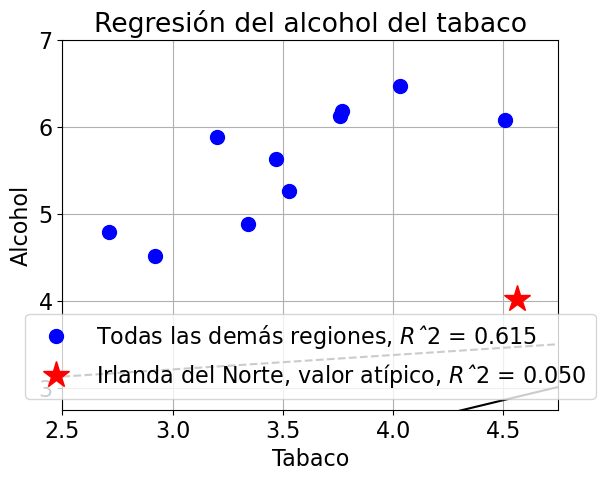

In [169]:
mpl.rcParams['font.size'] = 16

labelStart = 'Todas las demás regiones, $Rˆ2$ = '

plt.plot(df.Tobacco[:-1], df.Alcohol[:-1], 'bo', markersize=10,
          label=labelStart + clean_score )

#plt.hold(True)

labelStart = 'Irlanda del Norte, valor atípico, $Rˆ2$ = '
plt.plot( df.Tobacco[-1:], df.Alcohol[-1:], 'r*', ms=20, lw=10,
          label=labelStart+original_score)

test = np.arange( 2.5, 4.85, 0.1 )
test

test = np.c_[np.arange(2.5, 4.85, 0.1)]
plt.plot(test, cln.predict(test), 'k')
plt.plot(test, org.predict(test), 'k--')

plt.xlabel('Tabaco')
plt.xlim(2.5,4.75)
plt.ylabel('Alcohol')
plt.ylim(2.75,7.0)
plt.title('Regresión del alcohol del tabaco') ;
plt.grid() ;
plt.legend(loc='lower center')

plt.show()

## 12.4.7 Conclusión


Primero visualice sus datos. 

Si sus datos son muy dimensionales, al menos examine algunos cortes utilizando diagramas de caja. 

Use su propio juicio sobre un modelo basado en su conocimiento de su dominio. 

Las pruebas estadísticas deben guiar su razonamiento, pero no deben dominarlo. 

En la mayoría de los casos, sus datos no se alinearán con las suposiciones hechas por la mayoría de las pruebas disponibles. 

# 12.5 Supuestos e Interpretaciones de Regresión Lineal


## 12.5.1 Supuestos


1. Relación lineal: Debe haber una relación lineal en los datos

El ajuste lineal puede no tener sentido si se elige el modelo equivocado, o si algunas de las suposiciones no se cumplen. 

Para un ajuste significativo, la variable de respuesta debe ser una combinación lineal de los parámetros y las variables predictoras. 

Esta suposición es mucho menos restrictiva de lo que puede parecer a primera vista. 

Ej: si elevamos al cuadrado una variable y usamos los cuadrados como uno de los predictores, puede ajustar una curva polinomial a los datos con regresión lineal. 

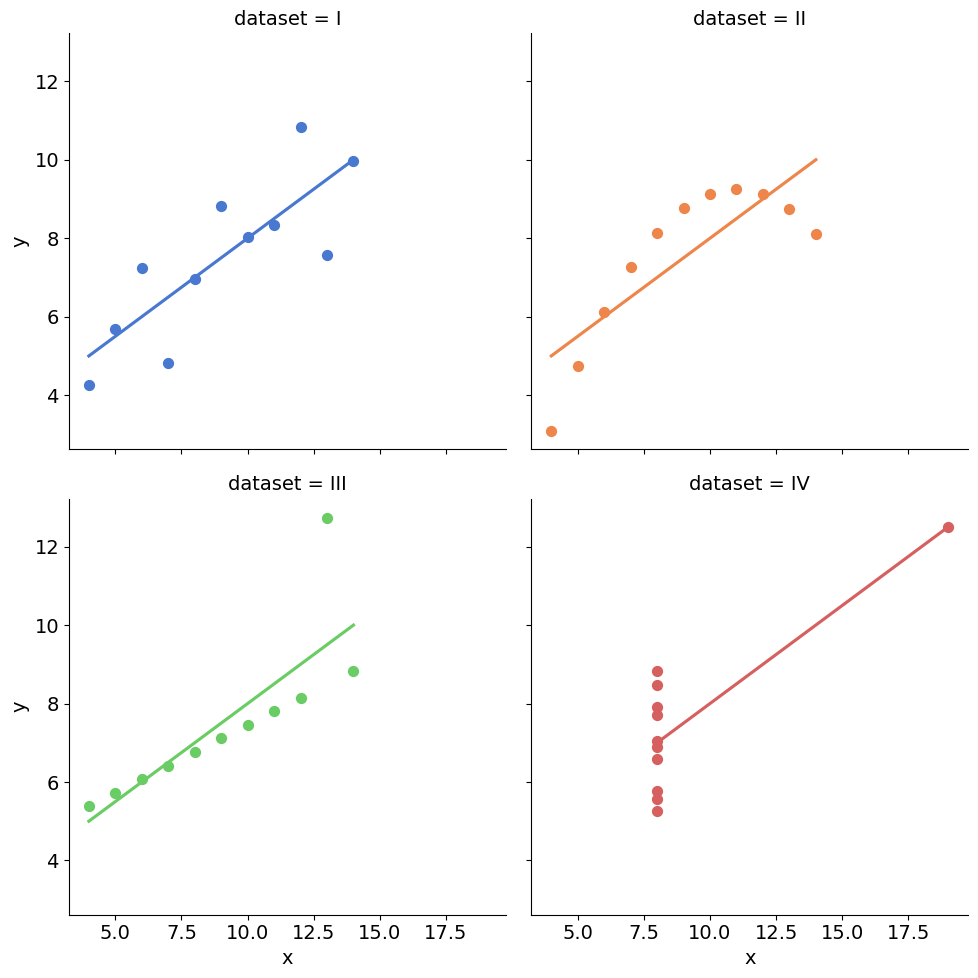

In [173]:
df = sns.load_dataset("anscombe")

# Show the results of a linear regression within each dataset
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
           col_wrap=2, ci=None, palette="muted", 
           scatter_kws={"s": 50, "alpha": 1})

plt.show()

2. Homocedasticidad: Igualdad de varianzas 

Varianza constante.

Diferentes respuestas variables tienen la misma varianza en sus errores, independientemente de los valores de las variables predictoras. 

Esta suposición suele ser inválida si las variables de respuesta pueden variar en gran escala. 

Ej: una persona determinada cuyos ingresos se predice que será de $\$100000$ fácilmente puede tener un ingreso real de $\$80000$ o $\$120000$ (una desviación estándar de alrededor de $\$20000$), mientras que otra persona con un ingreso previsto de $\$10000$ es poco probable que tenga la misma desviación estándar de $\$20000$, lo que implicaría que su ingreso real variaría entre $-\$10000$ y $\$30000$. 

Los métodos de estimación de RLS dan estimaciones de parámetros menos precisas y cantidades inferenciales engañosas, como errores estándar cuando existe heterocedasticidad sustancial. 

Un diagrama de dispersión de los residuos suele ser una buena manera de verificar: 
- Si los datos no son homocedásticos, lços residuales se estrechan o amplían sistemáticamente con valores predictivos crecientes. 

3. Independencia: Sin autocorrelación en los residuos 

Independencia de los errores: los errores de las variables de respuesta no deben estar correlacionados entre sí. 

Este no es el caso en series temporales: 

Ej: cuando la temperatura es alta hoy, lo más probable es que sea al menos cálido mañana. 

Las relaciones entre datos adyacentes pueden verse con la función de correlación automática y cuantificarse con la prueba de Durbin-Watson. 

4. Normalidad de los residuos 

Cuando el modelo describe bien los datos, los residuos deben estar normalmente distribuidos. 

Si los residuos cambian sistemáticamente con el valor de los predictores, el modelo  ha pasado por alto un aspecto importante de la datos.

5. Colinealidad escasa o nula: los predictores deben ser independientes 

Para los métodos estándar de estimación por MCO, la matriz de diseño X debe tener un rango de columna completo p

De lo contrario, tenemos multicolinealidad en las variables predictoras.

Puede desencadenarse al tener 2 o más variables predictoras correlacionadas. 

Ej: con el aumento de los ingresos, el número de niños suele disminuir, mientras que aumenta el tiempo que se pasa en una cancha de golf.

Si usamos ambas variables como predictores, los resultados de una regresión lineal conducirán a soluciones espurias.

Supuestos extra: 
- Las variables independientes se conocen exactamente
- Toda la variabilidad proviene de los residuos. 

In [174]:
# Datos
x = np.arange(5)
y = [3, 5, 6, 5, 7]

In [176]:
# Ajustar modelos lineales y(x), y x(y):
fit_x_independent = np.polyfit(x, y, 1)
fit_y_independent = np.polyfit(y, x, 1)

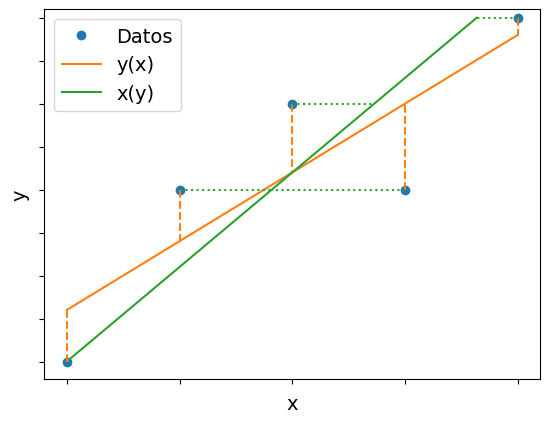

In [178]:
# Grafico
x_independent = np.linspace(0, 4, 100)
y_dependent = np.polyval(fit_x_independent, x_independent)

y_independent = np.linspace(3, 7, 100)
x_dependent = np.polyval(fit_y_independent, y_independent)

plt.plot(x, y, 'o', label='Datos')
plt.plot(x_independent, y_dependent, label='y(x)')
plt.plot(x_dependent, y_independent, label='x(y)')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-0.2, 4.2])
plt.ylim([2.8, 7.1])

ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])

# Residuos
y_fit = np.polyval(fit_x_independent, x)
x_fit = np.polyval(fit_y_independent, y)
for ii in range(len(x)):
    plt.vlines(x[ii], y[ii], y_fit[ii], ls='dashed', colors='C1')
    plt.hlines(y[ii], x[ii], x_fit[ii], ls='dotted', colors='C2')
    
plt.show()

Cuando ajustamos y(x), los valores de x son fijos, y los residuos en los valores de y (líneas discontinuas) se minimizan. 

Cuando encajamos x(y), los valores de y se mantienen fijos y los residuos punteados se minimizan. 

Los dos ajustes resultantes tienen diferentes inclinaciones.

Propiedades estadísticas de los datos que influyen en el rendimiento de diferentes métodos de estimación: 

- La relación estadística entre los términos de error y los regresores juega un papel importante para determinar si un procedimiento de estimación tiene propiedades de muestreo deseables, como ser imparcial y consistente.
- El arreglo, o distribución de probabilidad de las variables predictoras en $X$ tiene una gran influencia en la precisión de las estimaciones de $\beta$. 
    - El muestreo y el diseño de los experimentos son subcampos estadísticos altamente desarrollados que brindan orientación para recopilar datos de tal manera que se logre una estimación precisa de $\beta$.

## 12.5.2 Interpretación de modelos de regresión multilineal


Se puede usar un modelo de regresión lineal ajustado para identificar la relación entre una sola variable predictora $x_j$ y la variable de respuesta $y$ cuando todas las demás variables predictoras en el modelo se “mantienen fijas”.

$\beta_j$: es el cambio esperado en $y$ para un cambio de una unidad en $x_j$ cuando las otras covariables se mantienen fijas 

Efecto Único de $x_j$: valor esperado de la derivada parcial de $y$ con respecto a $x_j$

Efecto Marginal de $x_j$: se evalúa utilizando un coeficiente de correlación o un modelo de regresión lineal simple que relacione $x_j$ con $y$; 
- Es la derivada total de $y$ con respecto a $x_j$.

Algunos regresores 
- Pueden no permitir cambios marginales
    - Variables ficticias
    - Intercepción
    
- No se pueden mantener fijos.

Es posible que el efecto único sea casi nulo incluso cuando el efecto marginal es grande. 
- Puede implicar que alguna otra covariable captura toda la información en $x_j$, de modo que una vez que esa variable está en el modelo, no hay contribución de $x_j$ a la variación en $y$. 

El efecto único de $x_j$ puede ser grande mientras que su efecto marginal es casi cero. 
- Sucedería si las otras covariables explicaran gran parte de la variación de $y$, pero principalmente explican la variación de manera complementaria a lo que capta $x_j$. 
- Incluir las otras variables en el modelo reduce la parte de la variabilidad de $y$ que no está relacionada con $x_j$, fortaleciendo así la aparente relación con $x_j$.

Si el experimentador establece directamente los valores de las variables predictoras de acuerdo con un diseño de estudio, las comparaciones de interés pueden corresponder literalmente a comparaciones entre unidades cuyas variables predictoras han sido "mantenidas fijas" por el experimentador. 

La expresión "mantenido fijo" puede referirse a una selección que tiene lugar en el contexto del análisis de datos. 
- "Mantenemos una variable fija" restringiendo nuestra atención a los subconjuntos de datos que tienen un valor común para la variable predictora dada. 

Esta es la única interpretación de "mantenido fijo" que se puede utilizar en un estudio observacional.

La noción de un "efecto único" es atractiva cuando se estudia un sistema complejo donde múltiples componentes interrelacionados influyen en la variable de respuesta. 

Puede interpretarse como el efecto causal de una intervención que está vinculado al valor de una variable predictora. 

En muchos casos el análisis de regresión múltiple no aclara las relaciones entre las variables predictoras y la variable de respuesta cuando los predictores están correlacionados entre sí y no se asignan siguiendo un diseño de estudio.

In [179]:
data = pd.read_csv(r'Datos/swim100m.csv')
data

,year,time,sex
0,1905,65.80,M
1,1908,65.60,M
2,1910,62.80,M
3,1912,61.60,M
4,1918,61.40,M
...,...,...,...
57,1986,54.73,F
58,1992,54.48,F
59,1994,54.01,F
60,2000,53.77,F


In [181]:
model1 = smf.ols("time ~ sex", data).fit()
print((model1.summary()))

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     24.13
Date:                Tue, 01 Aug 2023   Prob (F-statistic):           7.28e-06
Time:                        20:34:26   Log-Likelihood:                -219.23
No. Observations:                  62   AIC:                             442.5
Df Residuals:                      60   BIC:                             446.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     65.1923      1.517     42.986      0.0

In [183]:
model2 = smf.ols("time ~ sex + year", data).fit()
print((model2.summary()))

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     159.6
Date:                Tue, 01 Aug 2023   Prob (F-statistic):           1.58e-24
Time:                        20:34:50   Log-Likelihood:                -172.12
No. Observations:                  62   AIC:                             350.2
Df Residuals:                      59   BIC:                             356.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    555.7168     33.800     16.441      0.0

In [184]:
model3 = smf.ols("time ~ sex * year", data).fit()
print((model3.summary()))

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     162.1
Date:                Tue, 01 Aug 2023   Prob (F-statistic):           3.67e-28
Time:                        20:35:11   Log-Likelihood:                -160.30
No. Observations:                  62   AIC:                             328.6
Df Residuals:                      58   BIC:                             337.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       697.3012     39.221     17.779

In [51]:
from statsmodels.stats.anova import anova_lm

In [187]:
anova_lm(model1)

,df,sum_sq,mean_sq,F,PR(>F)
sex,1.0,1720.655232,1720.655232,24.132575,0.000007
Residual,60.0,4278.006477,71.300108,NaN,NaN


In [188]:
anova_lm(model2)

,df,sum_sq,mean_sq,F,PR(>F)
sex,1.0,1720.655232,1720.655232,108.479881,5.475511e-15
year,1.0,3342.177104,3342.177104,210.709831,3.935386e-21
Residual,59.0,935.829374,15.861515,NaN,NaN


In [189]:
anova_lm(model3)

,df,sum_sq,mean_sq,F,PR(>F)
sex,1.0,1720.655232,1720.655232,156.140793,4.299569e-18
year,1.0,3342.177104,3342.177104,303.285733,1.039245e-24
sex:year,1.0,296.675432,296.675432,26.921801,2.826421e-06
Residual,58.0,639.153942,11.019896,NaN,NaN


In [190]:
np.random.seed(987654321)
t = np.arange(0,10,0.1)
y = 4 + 3*t + 2*t**2 + 5*np.random.randn(len(t))

In [191]:
# Haga el ajuste. 
# Tenga en cuenta que este es otro "OLS" que el de "model_formulas", ya que funciona directamente con la matriz de diseño.
M = np.column_stack((np.ones(len(t)), t, t**2))
res = sm.OLS(y, M).fit()
print((res.summary()))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     7907.
Date:                Tue, 01 Aug 2023   Prob (F-statistic):          3.77e-108
Time:                        20:40:58   Log-Likelihood:                -308.40
No. Observations:                 100   AIC:                             622.8
Df Residuals:                      97   BIC:                             630.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7424      1.579      3.004      0.0

In [195]:
print(f'Los parámetros ajustados son: {str(res.params)}\n')
print(f'IC:\n{res.conf_int()}')

Los parámetros ajustados son: [4.74244177 2.60675788 2.03793634]

IC:
[[1.60954008 7.87534347]
 [1.14418229 4.06933347]
 [1.89498149 2.1808912 ]]


# 12.6 Arranque automático (Bootstrapping)

A veces tenemos datos que describen una distribución, pero no sabemos qué tipo de distribución es. 

Es un esquema de remuestreo, es decir, toma muestras adicionales repetidamente de la muestra inicial, para proporcionar estimaciones de su variabilidad. 

En caso de que se desconozca la distribución de la muestra inicial, el Bootstrapping es de especial ayuda ya que proporciona información sobre la distribución. 

In [14]:
# Generar una muestra de datos no distribuida normalmente
np.random.seed(987654321)
data = stats.poisson.rvs(2, size=1000)

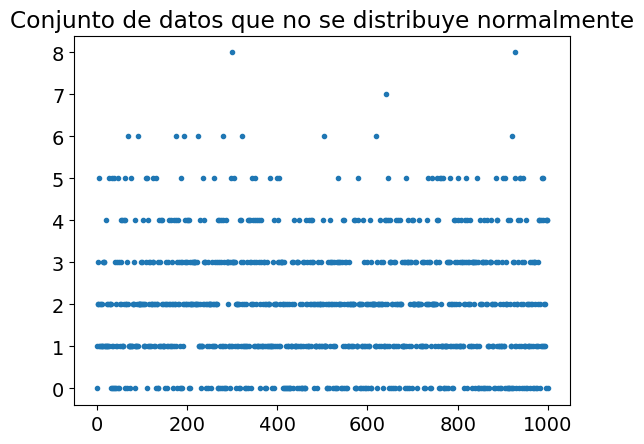

In [199]:
# Grafico
plt.plot(data, '.')

plt.title('Conjunto de datos que no se distribuye normalmente')

plt.show()

In [220]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

In [221]:
# Calculo el bootstrap
CIs = bs.bootstrap(data, stat_func=bs_stats.mean)
CIs # CONSULTAR

1.975    (1.8860000000000001, 2.0650000000000004)

# 12.7 Ejercicios


1. Observaciones pico

a) Correlación

Lea primero los datos de la temperatura media anual en Sonnblick, el observatorio meteorológico más alto de Austria, del archivo data/data_others/ avgtemp.xls. 

Luego calcule la correlación de Pearson y Spearman, y la tau de Kendall, para la temperatura en función del año. 

b) Regresión

Para los mismos datos, calcule el aumento anual de la temperatura, suponiendo un aumento con el tiempo. ¿Es significativo este aumento? 

c) Comprobación de normalidad 

Para los datos del modelo de regresión, verifique si el modelo está bien probado, si el los residuos se distribuyen normalmente (por ejemplo, mediante el uso de la prueba de Kolmogorov-Smirnov).

In [16]:
in_file = r'Datos\AvgTemp.xls'

xls = pd.ExcelFile(in_file)

data = xls.parse('Tabelle1')

data

,year,AvgTmp
0,1887,-7.5
1,1888,-6.8
2,1889,-7.1
3,1890,-7.0
4,1891,-6.7
...,...,...
117,2004,-5.2
118,2005,-5.7
119,2006,-4.5
120,2007,-4.5


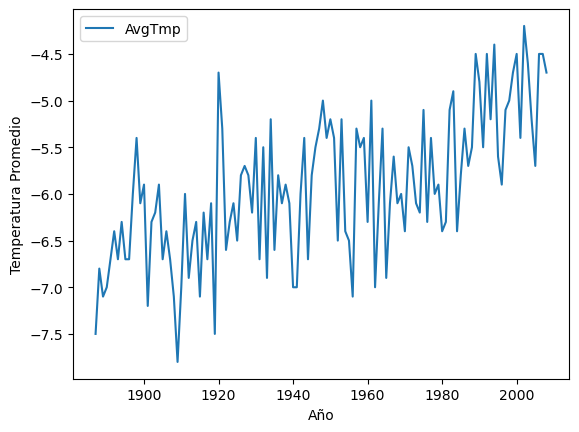

In [17]:
data.plot('year', 'AvgTmp')

plt.xlabel('Año')
plt.ylabel('Temperatura Promedio')

plt.show()

$\textbf{a)}$

In [18]:
pearson = data['year'].corr(data['AvgTmp'], method = 'pearson')

print(f'Coeficiente de correlación de Pearson: {pearson:4.3f}')

Coeficiente de correlación de Pearson: 0.639


In [19]:
spearman = data['year'].corr(data['AvgTmp'], method = 'spearman')

print(f'Coeficiente de correlación de Spearman: {spearman:4.3f}')

Coeficiente de correlación de Spearman: 0.629


In [20]:
tau = data['year'].corr(data['AvgTmp'], method = 'kendall')

print(f'Tau de Kendall: {tau:4.3f}')

Tau de Kendall: 0.459


$\textbf{b)}$

In [21]:
# Ajusto el modelo

model = smf.ols('AvgTmp ~ year', data)

results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 AvgTmp   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     82.74
Date:                Sat, 12 Aug 2023   Prob (F-statistic):           2.43e-15
Time:                        17:33:21   Log-Likelihood:                -109.46
No. Observations:                 122   AIC:                             222.9
Df Residuals:                     120   BIC:                             228.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -33.1840      2.996    -11.074      0.0

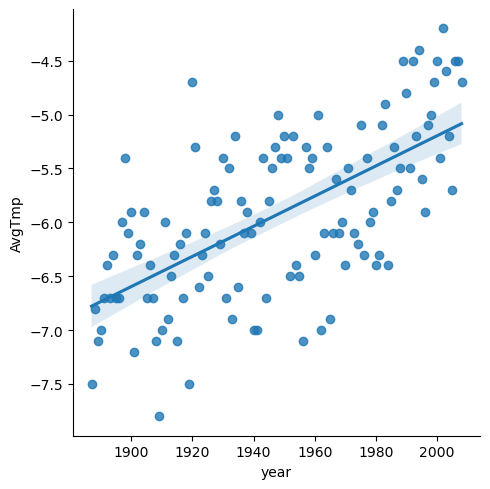

In [22]:
# Visualmente, los intervalos de confianza

sns.lmplot(x='year', y='AvgTmp', data=data)

plt.show()

In [11]:
ci = results.conf_int()

ci

,0,1
Intercept,-39.116796,-27.251122
year,0.010948,0.017040


In [23]:
# Si ambos están por encima o por debajo de cero, el producto es positivo:
   
coeficientes = ['Intercept','year']

for i in coeficientes:
    if np.prod(ci.loc[i])>0:
        print(f'{i} es significante')
    else: 
        print(f'{i} no es significante')

Intercept es significante
year es significante


$\textbf{c)}$

In [24]:
# Valores de los residuos

res_data = results.resid    

res_data

0     -0.722231
1     -0.036225
2     -0.350219
3     -0.264212
4      0.021794
         ...   
117   -0.059499
118   -0.573493
119    0.612514
120    0.598520
121    0.384526
Length: 122, dtype: float64

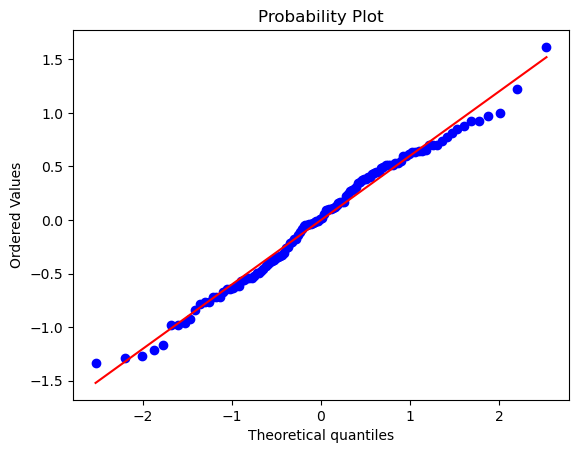

In [25]:
# QQ-plot

stats.probplot(res_data, plot=plt)

plt.show()

In [26]:
# Test de normalidad
testnorm = stats.normaltest(res_data)
testnorm

NormaltestResult(statistic=1.8283650726213543, pvalue=0.400844167748084)

In [27]:
pVal = testnorm.pvalue
pVal

0.400844167748084

In [28]:
alpha = 0.05

if pVal < alpha:
    print(f'Los datos no se distribuyen normalmente. (p = {pVal})')
else:
    print(f'Los datos se distribuyen normalmente. (p = {pVal:.3f})')

Los datos se distribuyen normalmente. (p = 0.401)


2. Crisis Climática

a) Lea los niveles de CO2 registrados en Mauna Loa en Hawái, de https://www.esrl.noaa.gov/gmd/webdata/ccgg/trends/co2/co2_mm_mlo.txt, y elimine las oscilaciones estacionales con la función statsmodels season_decompose.

b) Ajustar una curva lineal, cuadrática y cúbica a los datos, utilizando el lenguaje de fórmulas patsy. 

c) Grafique los datos y superpóngalos con los ajustes resultantes. 

d) Utilice los valores AIC resultantes para averiguar cuál de estas 3 curvas se ajusta mejor a los datos.

$\textbf{a)}$

In [3]:
url = 'https://www.esrl.noaa.gov/gmd/webdata/ccgg/trends/co2/co2_mm_mlo.txt'
df = pd.read_csv(url, skiprows=58, delim_whitespace=True, 
                 names = ['year', 'month', 'time', 'co2', 'deseasoned', 'nr_days', 'std_days', 'uncertainty'])
df.head()

,year,month,time,co2,deseasoned,nr_days,std_days,uncertainty
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99


In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
# Descomposición estacional
result_add = seasonal_decompose(df['co2'], model='additive', period=12, extrapolate_trend='freq')
result_add

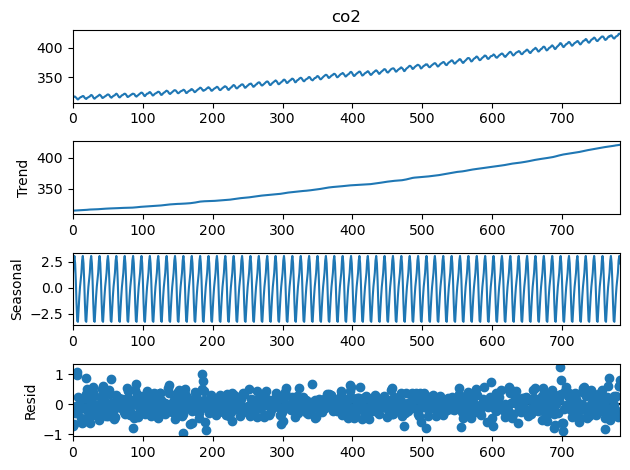

In [7]:
result_add.plot()

plt.show()

$\textbf{b)}$

In [10]:
df1 = pd.concat({'year': df.time, 'co2': result_add.trend}, axis=1)
df1

,year,co2
0,1958.2027,315.017963
1,1958.2877,315.078159
2,1958.3699,315.138354
3,1958.4548,315.198549
4,1958.5370,315.258744
...,...,...
779,2023.1250,419.815257
780,2023.2083,419.991386
781,2023.2917,420.167515
782,2023.3750,420.343644


In [11]:
linear = smf.ols('co2 ~ year', df).fit()
print(linear.summary())

                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 3.395e+04
Date:                Tue, 01 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:00:06   Log-Likelihood:                -2317.2
No. Observations:                 784   AIC:                             4638.
Df Residuals:                     782   BIC:                             4648.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2874.0681     17.544   -163.824      0.0

In [12]:
quadratic = smf.ols('co2 ~ year+I(year**2)', df).fit()
print(quadratic.summary())

                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 9.523e+04
Date:                Tue, 01 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:00:27   Log-Likelihood:                -1648.0
No. Observations:                 784   AIC:                             3302.
Df Residuals:                     781   BIC:                             3316.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4.946e+04    881.488     56.109   

In [13]:
cubic = smf.ols('co2 ~ year+I(year**2)+I(year**3)',df).fit()
print(cubic.summary())

                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 9.553e+04
Date:                Tue, 01 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:01:01   Log-Likelihood:                -1646.8
No. Observations:                 784   AIC:                             3300.
Df Residuals:                     781   BIC:                             3314.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0356      0.001     53.352   

$\textbf{c)}$

In [15]:
df1['linear'] = linear.predict()
df1['quadratic'] = quadratic.predict()
df1['cubic'] = cubic.predict()

In [18]:
df1

,year,co2,linear,quadratic,cubic
0,1958.2027,315.017963,305.723037,314.837286,314.758076
1,1958.2877,315.078159,305.723037,314.837286,314.758076
2,1958.3699,315.138354,305.723037,314.837286,314.758076
3,1958.4548,315.198549,305.723037,314.837286,314.758076
4,1958.5370,315.258744,305.723037,314.837286,314.758076
...,...,...,...,...,...
779,2023.1250,419.815257,411.283009,420.677564,420.767947
780,2023.2083,419.991386,411.283009,420.677564,420.767947
781,2023.2917,420.167515,411.283009,420.677564,420.767947
782,2023.3750,420.343644,411.283009,420.677564,420.767947


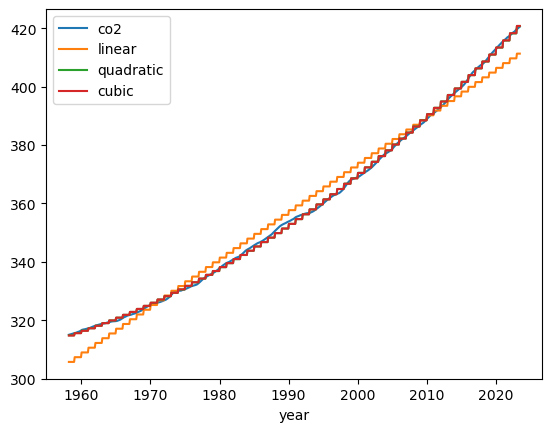

In [22]:
# Grafico
df1.plot('year', ['co2', 'linear', 'quadratic', 'cubic'])

plt.show()

$\textbf{d)}$

In [26]:
# Seleccione el mejor ajuste
aics = [linear.aic, quadratic.aic, cubic.aic]
index = np.argmin(aics)
print(f'El mejor ajuste es del orden {index+1}.')

El mejor ajuste es del orden 3.


# Apéndice 

##  1. Introducciones al uso de "modelos estadísticos" y "Pandas"

### 1.1 Ajuste de regresión lineal

In [29]:
np.random.seed(987654321)   

x = np.arange(100)
y = 0.5*x - 20 + np.random.randn(len(x))

df = pd.DataFrame({'x':x, 'y':y})

df.head()

,x,y
0,0,-17.753449
1,1,-20.145918
2,2,-20.183577
3,3,-16.570507
4,4,-17.933186


In [31]:
# MCO

model = smf.ols('y~x', data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.819e+04
Date:                Sat, 12 Aug 2023   Prob (F-statistic):          4.31e-113
Time:                        17:37:45   Log-Likelihood:                -147.60
No. Observations:                 100   AIC:                             299.2
Df Residuals:                      98   BIC:                             304.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.9742      0.212    -94.083      0.0

### 1.2 Ejemplo: ajuste de regresión lineal

"Estadística práctica para la investigación médica"

In [32]:
data = np.genfromtxt(r'Datos\altman_94.txt', delimiter=',')

data

array([[ 9.21,  0.  ],
       [ 7.53,  1.  ],
       [ 7.48,  1.  ],
       [ 8.08,  1.  ],
       [ 8.09,  1.  ],
       [10.15,  1.  ],
       [ 8.4 ,  1.  ],
       [10.88,  1.  ],
       [ 6.13,  1.  ],
       [ 7.9 ,  1.  ],
       [11.51,  0.  ],
       [12.79,  0.  ],
       [ 7.05,  1.  ],
       [11.85,  0.  ],
       [ 9.97,  0.  ],
       [ 7.48,  1.  ],
       [ 8.79,  0.  ],
       [ 9.69,  0.  ],
       [ 9.68,  0.  ],
       [ 7.58,  1.  ],
       [ 9.19,  0.  ],
       [ 8.11,  1.  ]])

In [33]:
# Bring them into pandas format

lean = pd.Series(data[data[:,1]==1,0])
obese = pd.Series(data[data[:,1]==0,0])

df = pd.DataFrame({'lean':lean, 'obese':obese})

df

,lean,obese
0,7.53,9.21
1,7.48,11.51
2,8.08,12.79
3,8.09,11.85
4,10.15,9.97
5,8.40,8.79
6,10.88,9.69
7,6.13,9.68
8,7.90,9.19
9,7.05,NaN


In [34]:
media = df.mean()

media

lean      8.066154
obese    10.297778
dtype: float64

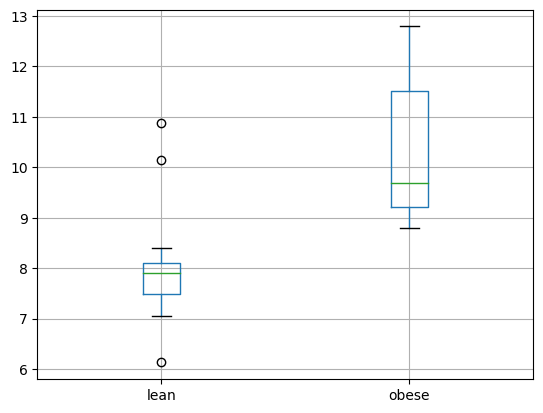

In [35]:
df.boxplot(return_type='axes')

plt.show()

In [36]:
t, pVal = stats.ttest_ind(lean, obese)

if pVal < 0.05:
    print(f'Hay una diferencia significativa: p = {pVal:.3f}')
else:
    print(f'No hay una diferencia significativa: p = {pVal:.3f}')

Hay una diferencia significativa: p = 0.001


## 2. Modelos de regresión

### 2.1 Ejemplo 1: Datos de salario de TI 

Estableceremos un modelo lineal, de salario en función de la experiencia, la educación y el nivel de gestión. 

Probaremos cualquier interacción entre estos factores. 

Las interacciones significativas se incluirán en el modelo. 

Finalmente, eliminaremos los valores atípicos y trazaremos los ajustes resultantes.

In [37]:
url = 'http://stats191.stanford.edu/data/salary.table'

salary_table = pd.read_table(url) 

salary_table.head()

,S,X,E,M
0,13876,1,1,1
1,11608,1,3,0
2,18701,1,3,1
3,11283,1,2,0
4,11767,1,3,0


In [38]:
E = salary_table.E # Educación

M = salary_table.M # Gestión

X = salary_table.X # Experiencia

S = salary_table.S # Salario

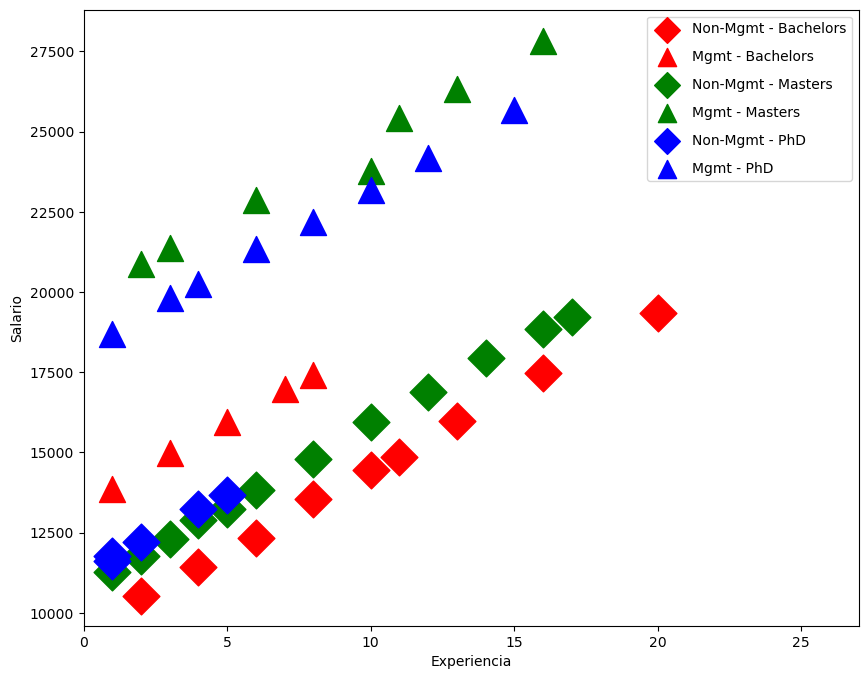

In [39]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(111, xlabel='Experiencia', ylabel='Salario', xlim=(0, 27), ylim=(9600, 28800))

symbols = ['D', '^']

man_label = ["Non-Mgmt", "Mgmt"]
educ_label = ["Bachelors", "Masters", "PhD"]

colors = ['r', 'g', 'blue']

factor_groups = salary_table.groupby(['E','M'])

for values, group in factor_groups:
    i,j = values
    label = "%s - %s" % (man_label[j], educ_label[i-1])
    ax.scatter(group['X'], group['S'], marker=symbols[j], color=colors[i-1], s=350, label=label)

ax.legend(scatterpoints=1, markerscale=.7, labelspacing=1)

plt.show()

Definir y ajustar un modelo lineal

Ajustar un modelo lineal

$$S_i = \beta_0 + \beta_1X_i + \beta_2E_{i2} + \beta_3E_{i3} + \beta_4M_i + \epsilon_i$$

donde

$$ E_{i2}=\cases{1,&if $E_i=2$;\cr 0,&otherwise. \cr}$$ 
$$ E_{i3}=\cases{1,&if $E_i=3$;\cr 0,&otherwise. \cr}$$ 

In [40]:
lm = smf.ols('S ~ C(E) + C(M) + X', salary_table).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     226.8
Date:                Sat, 12 Aug 2023   Prob (F-statistic):           2.23e-27
Time:                        18:03:36   Log-Likelihood:                -381.63
No. Observations:                  46   AIC:                             773.3
Df Residuals:                      41   BIC:                             782.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8035.5976    386.689     20.781      0.0

Dep Variable 
- La variable a ajustar
- El "Salario"

Model
- OLS = Mínimos Cuadrados Ordinarios

Df Residuals
- El número de observaciones, menos el número de parámetros ajustados.

Df model
- "Grado de libertad" del modelo, es decir, la dimensionalidad del subespacio abarcado por el modelo. 
- Esto implica que la intercepción no se cuenta.

R-squared
- Coeficiente de Determinación = (S0-Sm)/S0

Adj. R-squared
- El coeficiente R2 ajustado, que tiene en cuenta el número de parámetros del modelo.

F-statistic, y su correspondiente Prob
- Prueba F en el modelo de regresión, si es significativamente diferente del modelo mínimo (es decir, solo una compensación constante)

Log-Likelihood
- Valor máximo de log-verosimilitud para el modelo.

AIC
- Criterio de Información de Aiken, para la valoración del modelo.

BIC
- Criterio de Información Bayesiano, para la evaluación del modelo.

Los valores en el cuadro más bajo describen las propiedades de los residuales ("Skew", "Kurtosisi"), así como las pruebas de los residuales.

Inspeccione la matriz de diseño y demuestre las predicciones del modelo 

Mira la matriz de diseño creada para nosotros. 

Cada instancia de resultados tiene una referencia al modelo.

In [41]:
lm.model.exog[:10]

array([[1., 0., 0., 1., 1.],
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 0., 1.],
       [1., 0., 1., 0., 1.],
       [1., 1., 0., 1., 2.],
       [1., 1., 0., 0., 2.],
       [1., 0., 0., 0., 2.],
       [1., 0., 1., 0., 2.],
       [1., 1., 0., 0., 3.]])

Dado que inicialmente pasamos un DataFrame, tenemos un DataFrame transformado disponible.

In [43]:
lm.model.data.orig_exog.head(10)

,Intercept,C(E)[T.2],C(E)[T.3],C(M)[T.1],X
0,1.0,0.0,0.0,1.0,1.0
1,1.0,0.0,1.0,0.0,1.0
2,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,1.0
5,1.0,1.0,0.0,1.0,2.0
6,1.0,1.0,0.0,0.0,2.0
7,1.0,0.0,0.0,0.0,2.0
8,1.0,0.0,1.0,0.0,2.0
9,1.0,1.0,0.0,0.0,3.0


Hay una referencia a los datos originales intactos en

In [44]:
lm.model.data.frame.head(10)

,S,X,E,M
0,13876,1,1,1
1,11608,1,3,0
2,18701,1,3,1
3,11283,1,2,0
4,11767,1,3,0
5,20872,2,2,1
6,11772,2,2,0
7,10535,2,1,0
8,12195,2,3,0
9,12313,3,2,0


Si usa la interfaz de fórmula, statsmodels recuerda esta transformación. 

Supongamos que quiere saber el salario previsto para alguien con 12 años de experiencia y una maestría que se encuentra en un puesto gerencial.

In [45]:
lm.predict(pd.DataFrame({'X' : [12], 'M' : [1], 'E' : [2]}))

0    24617.372072
dtype: float64

Compruebe los residuos 

Hasta ahora hemos asumido que el efecto de la experiencia es el mismo para cada nivel de educación y rol profesional. 

Tal vez esta suposición no se merezca. 

Podemos probar esto formalmente usando algunas interacciones. 

Podemos comenzar por ver si se cumplen los supuestos de nuestro modelo. Veamos una gráfica de residuos, con los grupos separados.

In [46]:
resid = lm.resid

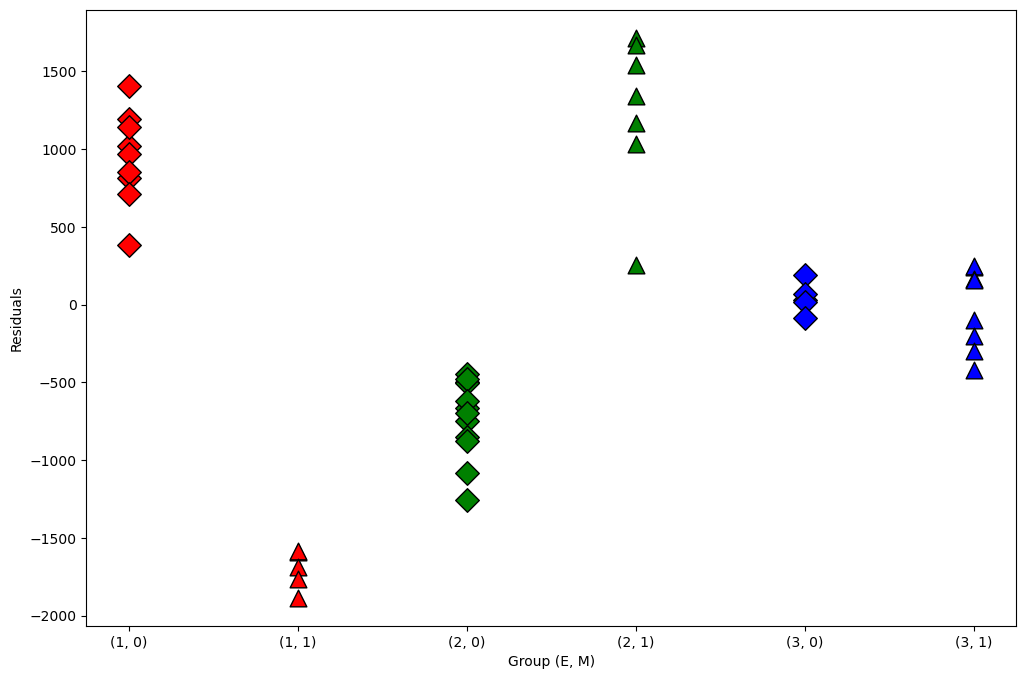

In [47]:
fig = plt.figure(figsize=(12,8))

xticks = []

ax = fig.add_subplot(111, xlabel='Group (E, M)', ylabel='Residuals')

for values, group in factor_groups:
    i,j = values
    xticks.append(str((i, j)))
    group_num = i*2 + j - 1 # for plotting purposes
    x = [group_num] * len(group)
    ax.scatter(x, resid[group.index], marker=symbols[j], color=colors[i-1], s=144, edgecolors='black')

ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels(xticks)
ax.axis('tight')

plt.show()

Obviamente, el modelo lineal por sí solo no captura todas las características del modelo, ya que los residuos no se distribuyen normalmente dentro de cada grupo. 

Para mejorar el modelo, verificamos si las interacciones entre los parámetros del modelo pueden explicar las diferencias del grupo.

Añadir una interacción

Interacción Salario*Experiencia

Agregue una interacción entre el salario y la experiencia, lo que permite diferentes intersecciones por nivel de experiencia.

$$S_i = \beta_0+\beta_1X_i+\beta_2E_{i2}+\beta_3E_{i3}+\beta_4M_i+\beta_5E_{i2}X_i+\beta_6E_{i3}X_i+\epsilon_i$$

In [49]:
interX_lm = smf.ols('S ~ C(E)*X + C(M)', salary_table).fit()

print(interX_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     158.6
Date:                Sat, 12 Aug 2023   Prob (F-statistic):           8.23e-26
Time:                        18:19:19   Log-Likelihood:                -379.47
No. Observations:                  46   AIC:                             772.9
Df Residuals:                      39   BIC:                             785.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    7256.2800    549.494     13.205      

La Experiencia "Factor" tiene los "Tratamientos" (o elementos) "1", "2" y "3". 

Dado que el "Tratamiento 1" ([T.1]) se toma como referencia, no se incluye aquí explícitamente. 

Esto se llama enfoque de "punto de esquina". 

Del mismo modo, la Gestión de "Factores" tiene los "Tratamientos" "0" y "1". Con "0" tomado como referencia, solo el término C(M)[T.1] aparece en el modelo. 

Las interacciones se describen mediante los términos "C(E)[T.i]:X".

Pruebe la gestión de interacción*Experiencia

$\beta_5 = \beta_6 = 0$. 

Podemos usar anova_lm o podemos usar una prueba F.

In [52]:
print(anova_lm(lm, interX_lm))

   df_resid           ssr  df_diff       ss_diff         F    Pr(>F)
0      41.0  4.328072e+07      0.0           NaN       NaN       NaN
1      39.0  3.941068e+07      2.0  3.870040e+06  1.914856  0.160964


In [53]:
print(interX_lm.f_test('C(E)[T.2]:X = C(E)[T.3]:X = 0'))

<F test: F=1.9148559281940776, p=0.16096422424743448, df_denom=39, df_num=2>


In [54]:
print(interX_lm.f_test([[0,0,0,0,0,1,-1],[0,0,0,0,0,0,1]]))

<F test: F=1.9148559281940776, p=0.16096422424743448, df_denom=39, df_num=2>


Ambas pruebas muestran que los modelos no son significativamente diferentes. 

En otras palabras, no hay efecto de interacción entre Gestión y Experiencia en los datos. 

Recuerde que las pruebas F son de la forma $R\beta = q$

In [55]:
LC = interX_lm.model.data.orig_exog.design_info.linear_constraint('C(E)[T.2]:X = C(E)[T.3]:X = 0')

print(LC.coefs)

print(LC.constants)

[[ 0.  0.  0.  0.  0.  1. -1.]
 [ 0.  0.  0.  0.  0.  0.  1.]]
[[0.]
 [0.]]


Interactuar la educación con la gestión

In [57]:
interM_lm = smf.ols('S ~ X + C(E)*C(M)', salary_table).fit()

print(interM_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5517.
Date:                Sat, 12 Aug 2023   Prob (F-statistic):           1.67e-55
Time:                        18:22:27   Log-Likelihood:                -298.74
No. Observations:                  46   AIC:                             611.5
Df Residuals:                      39   BIC:                             624.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            9472.6854    

In [58]:
print(anova_lm(lm, interM_lm))

   df_resid           ssr  df_diff       ss_diff           F        Pr(>F)
0      41.0  4.328072e+07      0.0           NaN         NaN           NaN
1      39.0  1.178168e+06      2.0  4.210255e+07  696.844466  3.025504e-31


El efecto de interacción Gestión*Educación es muy significativo

Comprobar los residuos del modelo ampliado

In [59]:
infl = interM_lm.get_influence()

resid = infl.resid_studentized_internal

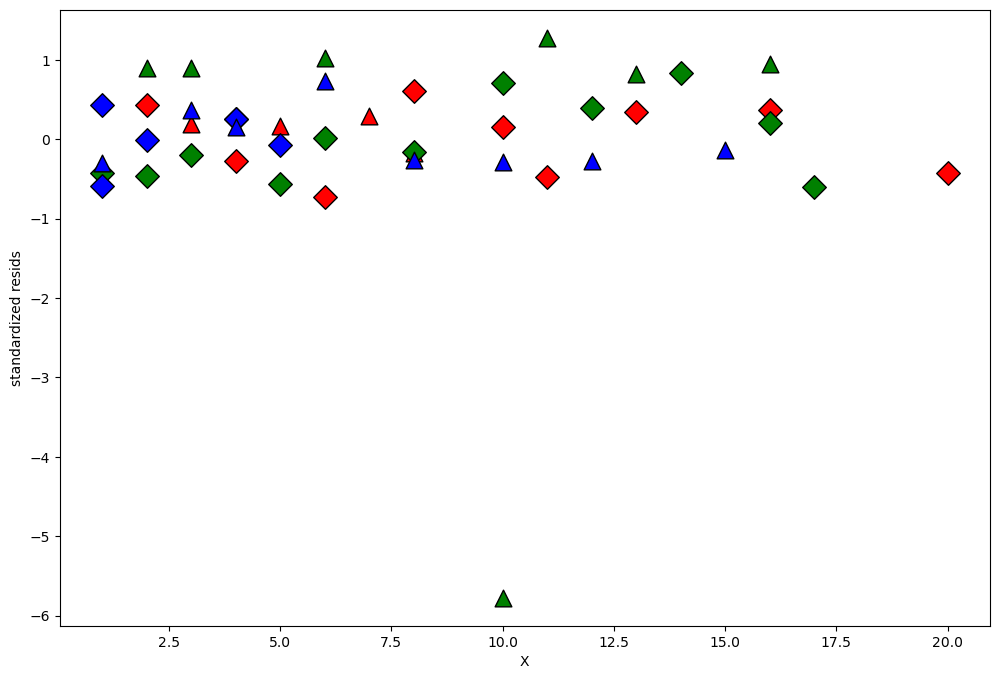

In [60]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111, xlabel='X', ylabel='standardized resids')

for values, group in factor_groups:
    i,j = values
    idx = group.index
    ax.scatter(X[idx], resid[idx], marker=symbols[j], color=colors[i-1], s=144, edgecolors='black')

ax.axis('tight')

plt.show()

Parece que hay un caso atípico.

Buscar y eliminar el valor atípico

In [61]:
outl = interM_lm.outlier_test('fdr_bh')

outl.sort_values(by='unadj_p', inplace=True)

print(outl)

    student_resid       unadj_p     fdr_bh(p)
32     -14.950832  1.676948e-17  7.713960e-16
33       1.288001  2.055339e-01  9.599254e-01
23       1.023194  3.126860e-01  9.599254e-01
41       0.942329  3.519767e-01  9.599254e-01
11       0.896574  3.755915e-01  9.599254e-01
5        0.890643  3.787254e-01  9.599254e-01
39       0.835081  4.088920e-01  9.599254e-01
38       0.819164  4.178011e-01  9.599254e-01
21       0.729762  4.700104e-01  9.599254e-01
20      -0.726132  4.722071e-01  9.599254e-01
30       0.704477  4.854309e-01  9.599254e-01
28       0.603122  5.500109e-01  9.599254e-01
44      -0.599720  5.522526e-01  9.599254e-01
1       -0.590487  5.583601e-01  9.599254e-01
17      -0.564832  5.755078e-01  9.599254e-01
0       -0.482474  6.322368e-01  9.599254e-01
34      -0.474793  6.376517e-01  9.599254e-01
6       -0.464031  6.452728e-01  9.599254e-01
7        0.428795  6.704934e-01  9.599254e-01
45      -0.426443  6.721915e-01  9.599254e-01
4        0.424446  6.736338e-01  9

In [62]:
to_drop = 32

idx = salary_table.index.drop(to_drop)

In [63]:
print(idx)

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45],
      dtype='int64')


Vuelva a ejecutar el modelo lineal original sin el valor atípico

In [65]:
lm32 = smf.ols('S ~ C(E) + X + C(M)', data=salary_table, subset=idx).fit()

print(lm32.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     211.7
Date:                Sat, 12 Aug 2023   Prob (F-statistic):           2.45e-26
Time:                        18:24:23   Log-Likelihood:                -373.79
No. Observations:                  45   AIC:                             757.6
Df Residuals:                      40   BIC:                             766.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8044.7518    392.781     20.482      0.0

Interacción Educación*Experiencia

In [67]:
interX_lm32 = smf.ols('S ~ C(E) * X + C(M)', data=salary_table, subset=idx).fit()

print(interX_lm32.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     147.7
Date:                Sat, 12 Aug 2023   Prob (F-statistic):           8.97e-25
Time:                        18:24:51   Log-Likelihood:                -371.70
No. Observations:                  45   AIC:                             757.4
Df Residuals:                      38   BIC:                             770.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    7266.0887    558.872     13.001      

In [68]:
table3 = anova_lm(lm32, interX_lm32)

print(table3)

   df_resid           ssr  df_diff       ss_diff         F    Pr(>F)
0      40.0  4.320910e+07      0.0           NaN       NaN       NaN
1      38.0  3.937424e+07      2.0  3.834859e+06  1.850508  0.171042


Una vez más, esto no es significativo y puede omitirse.

Resultado final

Resultado de la prueba de interacción: el modelo significativo con Interaction Experience*Management, sin el valor atípico #32

In [70]:
interM_lm32 = smf.ols('S ~ X + C(E) * C(M)', data=salary_table, subset=idx).fit()

print(anova_lm(lm32, interM_lm32))

   df_resid           ssr  df_diff       ss_diff            F        Pr(>F)
0      40.0  4.320910e+07      0.0           NaN          NaN           NaN
1      38.0  1.711881e+05      2.0  4.303791e+07  4776.734853  2.291239e-46


Volver a graficar los residuos

In [71]:
resid

array([-0.48729115, -0.5954801 , -0.29517124, -0.4230286 ,  0.42897925,
        0.89301298, -0.46877102,  0.43335347, -0.01549185, -0.19716976,
        0.1932281 ,  0.89883686,  0.36201307, -0.27198058,  0.14988891,
        0.25516709,  0.25303223, -0.56982837, -0.07340216,  0.16726751,
       -0.73057304,  0.73417535,  0.01639955,  1.022579  ,  0.29055183,
       -0.16376864, -0.16808615, -0.26295279,  0.60810224,  0.14917126,
        0.70907133, -0.28850311, -5.77349886,  1.27725604, -0.47957968,
        0.38658255, -0.2783867 ,  0.34649164,  0.82264053,  0.83833986,
       -0.13158075,  0.94368563,  0.19833606,  0.36478747, -0.60470452,
       -0.43098731])

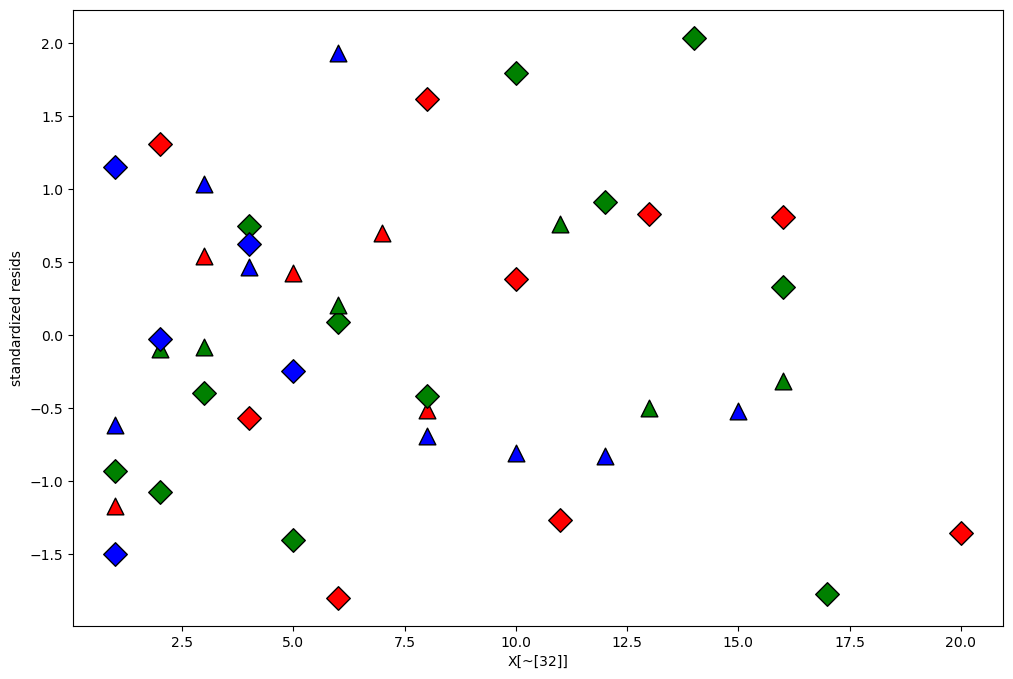

In [72]:
resid = interM_lm32.get_influence().summary_frame()['standard_resid']

fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111, xlabel='X[~[32]]', ylabel='standardized resids')

for values, group in factor_groups:
    i,j = values
    idx = group.index
    if to_drop in idx:
        idx = idx.drop(to_drop)
    if len(idx)>0:
        ax.scatter(X[idx], resid[idx], marker=symbols[j], color=colors[i-1], s=144, edgecolors='black')
ax.axis('tight')

plt.show()

Un gráfico final de los valores ajustados

In [74]:
lm_final = smf.ols('S ~ X + C(E)*C(M)', data=salary_table.drop([32])).fit()

print(lm_final.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.543e+04
Date:                Sat, 12 Aug 2023   Prob (F-statistic):           1.30e-69
Time:                        18:27:25   Log-Likelihood:                -249.34
No. Observations:                  45   AIC:                             512.7
Df Residuals:                      38   BIC:                             525.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            9458.3778    

In [76]:
mf = lm_final.model.data.orig_exog

mf.head()

,Intercept,C(E)[T.2],C(E)[T.3],C(M)[T.1],C(E)[T.2]:C(M)[T.1],C(E)[T.3]:C(M)[T.1],X
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,1.0,1.0,0.0,1.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0


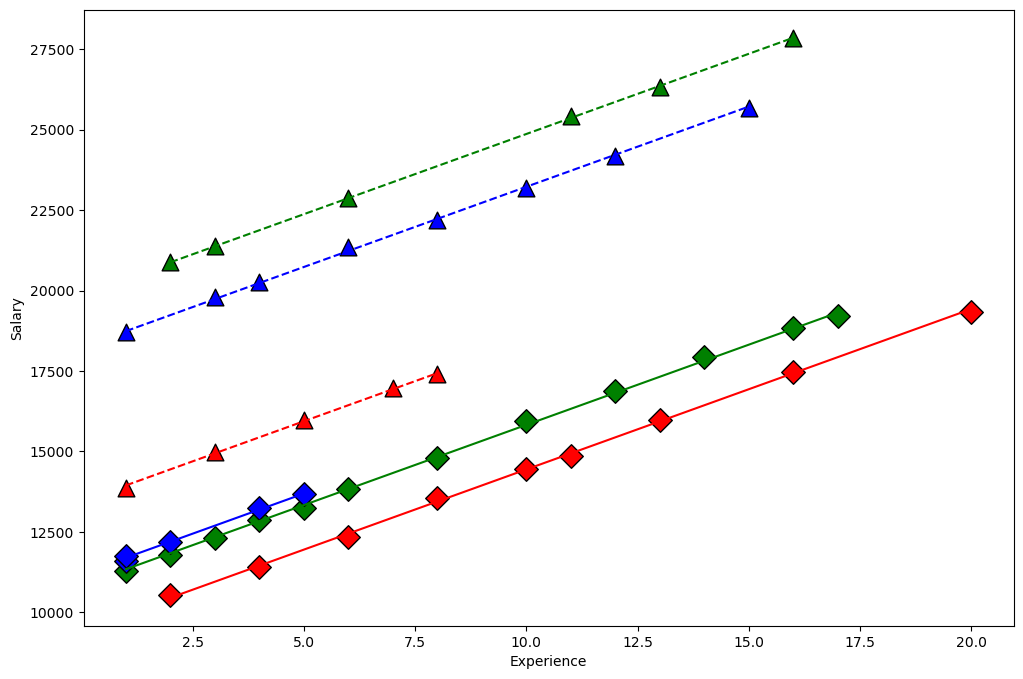

In [77]:
lstyle = ['-','--']

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='Experience', ylabel='Salary')

for values, group in factor_groups:
    i,j = values
    idx = group.index
    if to_drop in idx:
        idx = idx.drop(to_drop)
    ax.scatter(X[idx], S[idx], marker=symbols[j], color=colors[i-1],
            s=144, edgecolors='black')
    # drop NA because there is no idx 32 in the final model
    ax.plot(mf.X[idx].dropna(), lm_final.fittedvalues[idx].dropna(),
            ls=lstyle[j], color=colors[i-1])
ax.axis('tight')

plt.show()

Interacción Parcela Salario | Experiencia 

Desde nuestro primer vistazo a los datos, la diferencia entre maestría y doctorado en el grupo de gestión es diferente a la del grupo sin gestión. 

Esta es una interacción entre las dos variables cualitativas administración, M y educación, E. 

Podemos visualizar esto eliminando primero el efecto de la experiencia y luego trazando las medias dentro de cada uno de los 6 grupos usando interacción.plot.

In [79]:
from statsmodels.graphics.api import interaction_plot

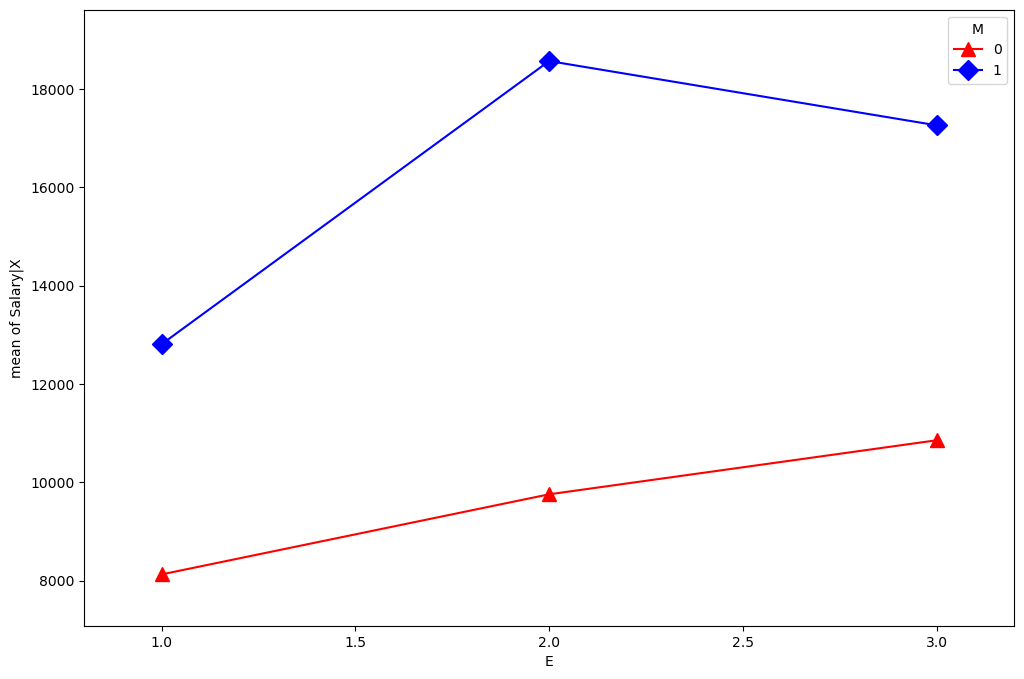

In [80]:
U = S - X * interX_lm32.params['X']

U.name = 'Salary|X'

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = interaction_plot(E, M, U, colors=['red','blue'], markers=['^','D'], markersize=10, ax=ax)

plt.show()

### 2.2 Ejemplo 2: Datos de Empleo de Minorías - Trazado ABLine

In [82]:
from urllib.request import urlopen

In [83]:
url_base = 'https://raw.githubusercontent.com/thomas-haslwanter/statsintro_python/master/ipynb/Data/data_others/'

inFile = 'minority.table'

url = url_base + inFile

minority_table = pd.read_table(urlopen(url))

#minority_table = pd.read_csv(r'.\Data\data_others\minority.table')

minority_table.to_csv('minority.table', sep="\t", index=False)

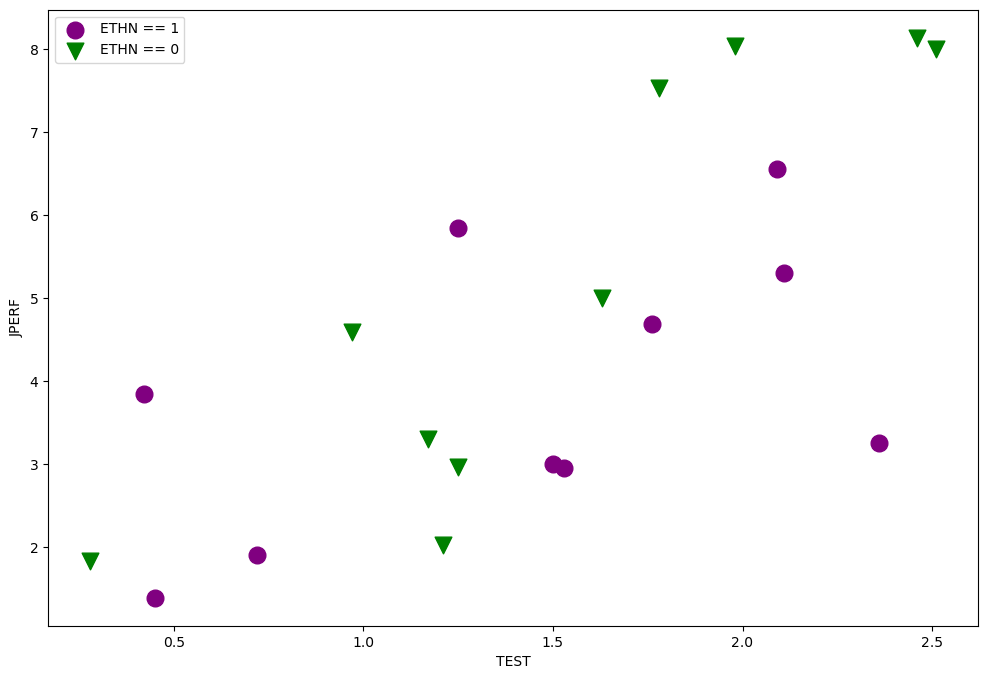

In [89]:
factor_group = minority_table.groupby(['ETHN'])

fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(111, xlabel='TEST', ylabel='JPERF')

colors = ['purple', 'green']
markers = ['o', 'v']

for factor, group in factor_group:
    eth_value = factor[0]  
    ax.scatter(group['TEST'], group['JPERF'], color=colors[eth_value], marker=markers[eth_value], s=12**2)

ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1)

plt.show()

In [91]:
min_lm = smf.ols('JPERF ~ TEST', data=minority_table).fit()

print(min_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  JPERF   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     19.25
Date:                Sat, 12 Aug 2023   Prob (F-statistic):           0.000356
Time:                        18:40:36   Log-Likelihood:                -36.614
No. Observations:                  20   AIC:                             77.23
Df Residuals:                      18   BIC:                             79.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0350      0.868      1.192      0.2

In [94]:
from statsmodels.graphics.api import abline_plot

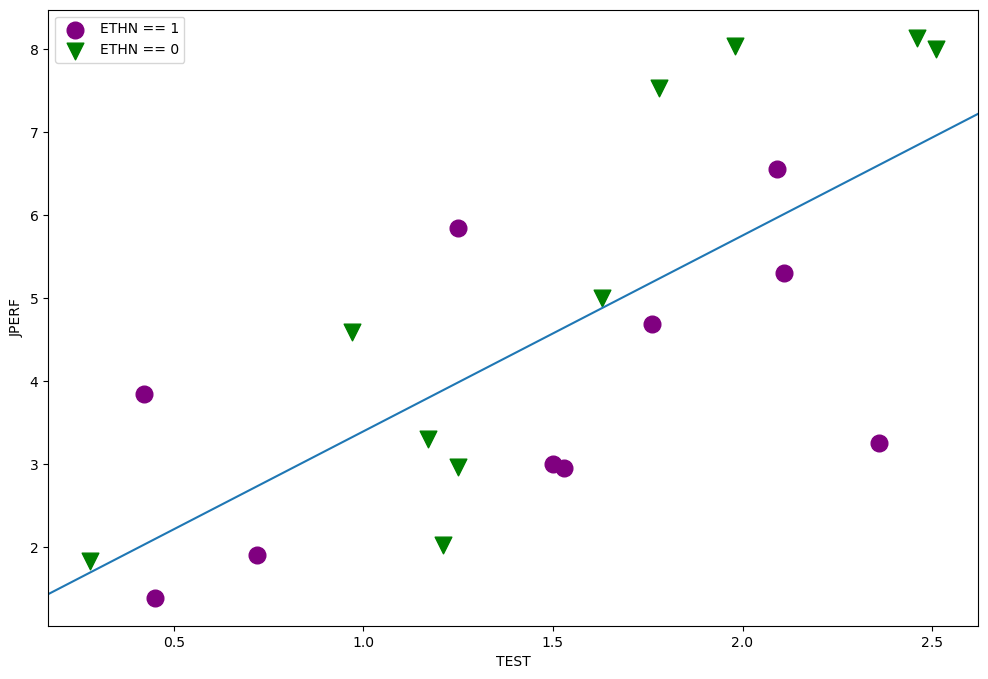

In [95]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(111, xlabel='TEST', ylabel='JPERF')

for factor, group in factor_group:
    eth_value = factor[0]  
    ax.scatter(group['TEST'], group['JPERF'], color=colors[eth_value], marker=markers[eth_value], s=12**2)

ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1, loc='upper left')

fig = abline_plot(model_results=min_lm, ax=ax)

plt.show()

In [97]:
min_lm2 = smf.ols('JPERF ~ TEST + TEST:ETHN', data=minority_table).fit()

print(min_lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                  JPERF   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     14.59
Date:                Sat, 12 Aug 2023   Prob (F-statistic):           0.000204
Time:                        18:42:39   Log-Likelihood:                -33.891
No. Observations:                  20   AIC:                             73.78
Df Residuals:                      17   BIC:                             76.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1211      0.780      1.437      0.1

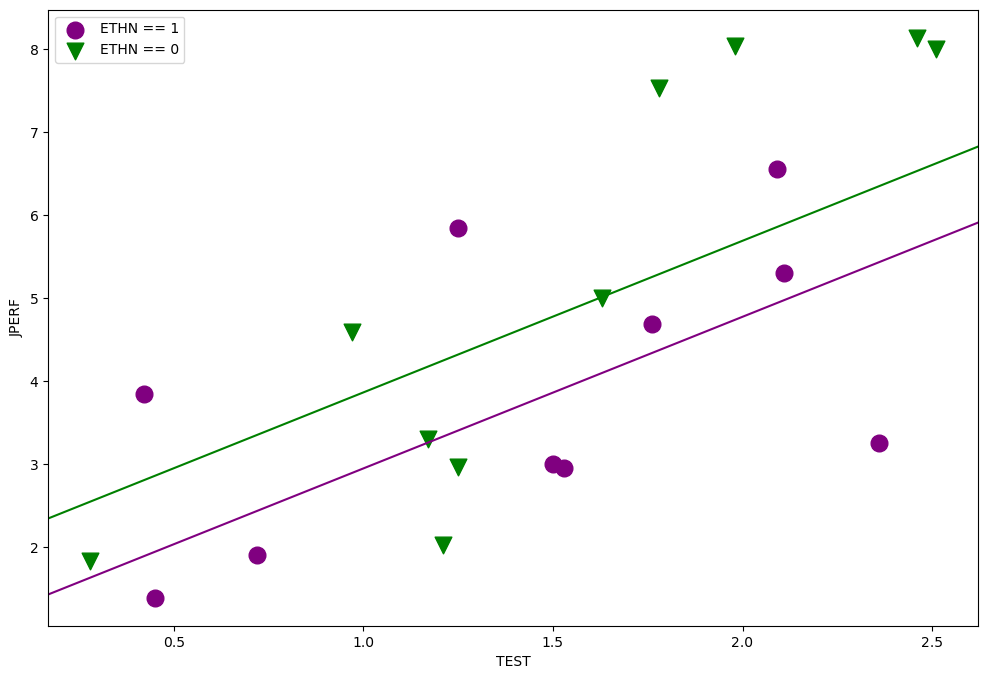

In [99]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, xlabel='TEST', ylabel='JPERF')

for factor, group in factor_group:
    eth_value = factor[0]  
    ax.scatter(group['TEST'], group['JPERF'], color=colors[eth_value], marker=markers[eth_value], s=12**2)

fig = abline_plot(intercept=min_lm2.params['Intercept'], slope=min_lm2.params['TEST'], ax=ax, color='purple')
ax = fig.axes[0]
fig = abline_plot(intercept=min_lm2.params['Intercept'] + min_lm2.params['TEST:ETHN'], slope=min_lm2.params['TEST'], ax=ax, color='green')

ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1, loc='upper left')

plt.show()

In [101]:
min_lm3 = smf.ols('JPERF ~ TEST + ETHN', data=minority_table).fit()

print(min_lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                  JPERF   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     11.38
Date:                Sat, 12 Aug 2023   Prob (F-statistic):           0.000731
Time:                        18:43:34   Log-Likelihood:                -35.390
No. Observations:                  20   AIC:                             76.78
Df Residuals:                      17   BIC:                             79.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6120      0.887      0.690      0.5

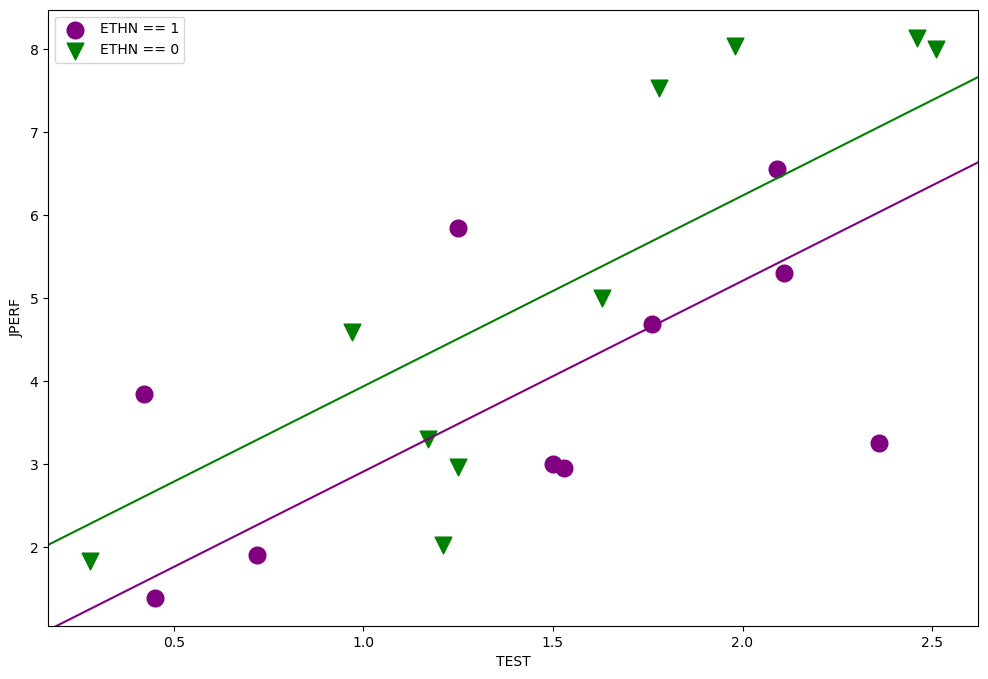

In [104]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, xlabel='TEST', ylabel='JPERF')

for factor, group in factor_group:
    eth_value = factor[0]  
    ax.scatter(group['TEST'], group['JPERF'], color=colors[eth_value], marker=markers[eth_value], s=12**2)

fig = abline_plot(intercept=min_lm3.params['Intercept'], slope=min_lm3.params['TEST'], ax=ax, color='purple')
ax = fig.axes[0]
fig = abline_plot(intercept=min_lm3.params['Intercept'] + min_lm3.params['ETHN'], slope=min_lm3.params['TEST'], ax=ax, color='green')

ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1, loc='upper left')

plt.show()

In [105]:
min_lm4 = smf.ols('JPERF ~ TEST * ETHN', data=minority_table).fit()

print(min_lm4.summary())

                            OLS Regression Results                            
Dep. Variable:                  JPERF   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     10.55
Date:                Sat, 12 Aug 2023   Prob (F-statistic):           0.000451
Time:                        18:46:05   Log-Likelihood:                -32.971
No. Observations:                  20   AIC:                             73.94
Df Residuals:                      16   BIC:                             77.92
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0103      1.050      1.914      0.0

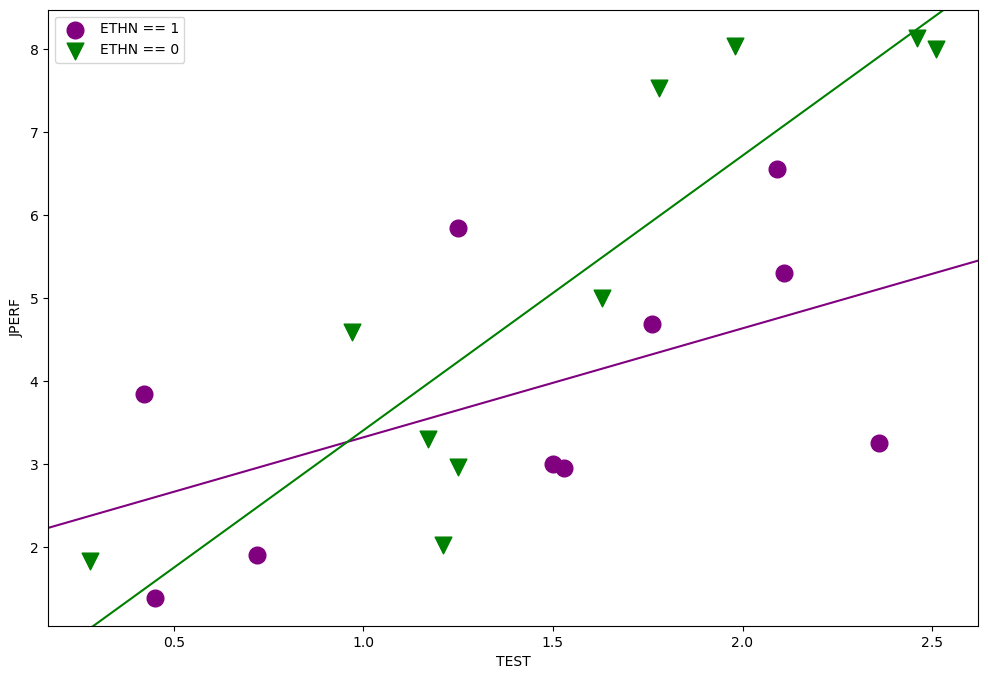

In [107]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, ylabel='JPERF', xlabel='TEST')

for factor, group in factor_group:
    eth_value = group['ETHN'].iloc[0]  
    ax.scatter(group['TEST'], group['JPERF'], color=colors[eth_value], marker=markers[eth_value], s=12**2)

fig = abline_plot(intercept=min_lm4.params['Intercept'], slope=min_lm4.params['TEST'], ax=ax, color='purple')
ax = fig.axes[0]
fig = abline_plot(intercept=min_lm4.params['Intercept'] + min_lm4.params['ETHN'], slope=min_lm4.params['TEST'] + min_lm4.params['TEST:ETHN'], ax=ax, color='green')

ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1, loc='upper left')

plt.show()

¿Hay algún efecto de ETHN en la pendiente o la intercepción?
<br />
$Y ~ TEST$ vs. $Y ~ TEST + ETHN + ETHN:TEST$

In [108]:
table5 = anova_lm(min_lm, min_lm4)

print(table5)

   df_resid        ssr  df_diff    ss_diff         F    Pr(>F)
0      18.0  45.568297      0.0        NaN       NaN       NaN
1      16.0  31.655473      2.0  13.912824  3.516061  0.054236


¿Hay algún efecto de ETHN en la intercepción?
<br />
$Y ~ TEST$ vs. $Y ~ TEST + ETHN$

In [109]:
table6 = anova_lm(min_lm, min_lm3)

print(table6)

   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      18.0  45.568297      0.0       NaN       NaN       NaN
1      17.0  40.321546      1.0  5.246751  2.212087  0.155246


¿Hay algún efecto de ETHN en la pendiente?
<br />
$Y ~ TEST$ vs. $Y ~ TEST + ETHN:TEST$

In [110]:
table7 = anova_lm(min_lm, min_lm2)

print(table7)

   df_resid        ssr  df_diff    ss_diff         F    Pr(>F)
0      18.0  45.568297      0.0        NaN       NaN       NaN
1      17.0  34.707653      1.0  10.860644  5.319603  0.033949


¿Es solo la pendiente o ambas?
<br />
$Y ~ TEST + ETHN:TEST$ vs $Y ~ TEST + ETHN + ETHN:TEST$

In [111]:
table8 = anova_lm(min_lm2, min_lm4)

print(table8)

   df_resid        ssr  df_diff  ss_diff         F    Pr(>F)
0      17.0  34.707653      0.0      NaN       NaN       NaN
1      16.0  31.655473      1.0  3.05218  1.542699  0.232115


### 2.3 ANOVA de dos vías: datos de insuficiencia renal

In [112]:
kidney_table = pd.read_csv(r'Datos\kidney.table', delim_whitespace=True)

kidney_table

,Days,Duration,Weight,ID
0,0.0,1,1,1
1,2.0,1,1,2
2,1.0,1,1,3
3,3.0,1,1,4
4,0.0,1,1,5
5,2.0,1,1,6
6,0.0,1,1,7
7,5.0,1,1,8
8,6.0,1,1,9
9,8.0,1,1,10


In [113]:
kidney_table.groupby(['Weight', 'Duration']).size()

Weight  Duration
1       1           10
        2           10
2       1           10
        2           10
3       1           10
        2           10
dtype: int64

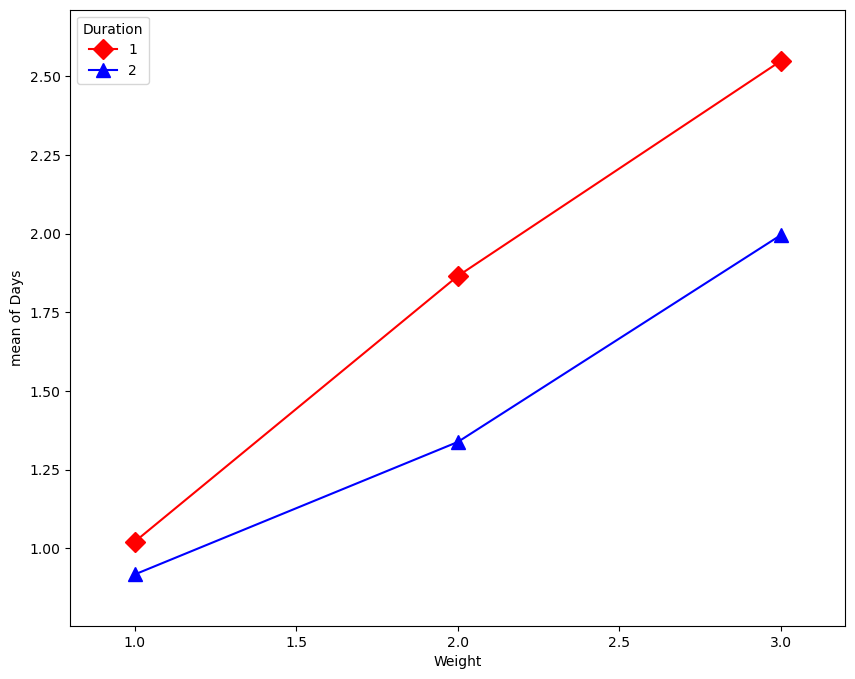

In [114]:
kt = kidney_table

fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(111)

fig = interaction_plot(kt['Weight'], kt['Duration'], np.log(kt['Days']+1), colors=['red', 'blue'], markers=['D','^'], ms=10, ax=ax)

plt.show()

$$Y_{ijk} = \mu + \alpha_i + \beta_j + \left(\alpha\beta\right)_{ij}+\epsilon_{ijk}$$

con

$$\epsilon_{ijk}\sim N\left(0,\sigma^2\right)$$

Las cosas disponibles en el espacio de nombres de llamadas están disponibles en el espacio de nombres de evaluación de fórmulas

In [115]:
kidney_lm = smf.ols('np.log(Days+1) ~ C(Duration) * C(Weight)', data=kt).fit()

print(kidney_lm.summary())

                            OLS Regression Results                            
Dep. Variable:       np.log(Days + 1)   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     7.431
Date:                Sat, 12 Aug 2023   Prob (F-statistic):           2.30e-05
Time:                        18:55:09   Log-Likelihood:                -63.314
No. Observations:                  60   AIC:                             138.6
Df Residuals:                      54   BIC:                             151.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

ANOVA Tipo-I Suma de cuadrados
<br /><br />
SS(A) para el factor A. <br />
SS(B|A) para el factor B. <br />
SS(AB|B, A) para la interacción AB. <br />

In [117]:
anova_lm(kidney_lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(Duration),1.0,2.339693,2.339693,4.358293,0.041562
C(Weight),2.0,16.971291,8.485645,15.806745,0.000004
C(Duration):C(Weight),2.0,0.635658,0.317829,0.592040,0.556748
Residual,54.0,28.989198,0.536837,NaN,NaN


ANOVA Tipo-I Suma de cuadrados

SS(A|B) para el factor A.<br />
SS(B|A) para el factor B.

In [118]:
anova_lm(kidney_lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Duration),2.339693,1.0,4.358293,0.041562
C(Weight),16.971291,2.0,15.806745,0.000004
C(Duration):C(Weight),0.635658,2.0,0.592040,0.556748
Residual,28.989198,54.0,NaN,NaN


ANOVA Tipo-III Suma de cuadrados
<br /><br />
SS(A|B, AB) para el factor A. <br />
SS(B|A, AB) para el factor B. <br />

In [120]:
anova_lm(smf.ols('np.log(Days+1) ~ C(Duration, Sum) * C(Weight, Poly)', data=kt).fit(), typ=3)

,sum_sq,df,F,PR(>F)
Intercept,156.301830,1.0,291.153237,2.077589e-23
"C(Duration, Sum)",2.339693,1.0,4.358293,4.156170e-02
"C(Weight, Poly)",16.971291,2.0,15.806745,3.944502e-06
"C(Duration, Sum):C(Weight, Poly)",0.635658,2.0,0.592040,5.567479e-01
Residual,28.989198,54.0,NaN,NaN
